## Step Comparison

In [1]:
import copy
import sys
import json
import os
import numpy as np
from roosts.tracking.tracker import Tracker
from roosts.utils.postprocess import Postprocess
from pycocotools.coco import COCO
from roosts.evaluation.roosteval import COCOeval
import matplotlib.pyplot as plt

exp = "0.0dev" # "3.2eval_resnet101-FPN_detptr_anc10_regsl1_imsz1200_lr0.001_it150k_ckpt39999_strt1"
data_root = "/scratch2/wenlongzhao/roosts/libs/"
dataset_name = "roosts_v0.1.0_test"
task = "bbox"
image_height = 600
coco_evals = []

def evaluate(predictions):
    coco_gt = COCO(os.path.join(exp, f"{dataset_name}_coco_format.json"))
    coco_dt = coco_gt.loadRes(predictions)

    coco_eval = COCOeval(coco_gt, coco_dt, task)
    coco_eval.evaluate()
    coco_eval.accumulate()
    return coco_eval

In [2]:
with open(os.path.join(exp, f"{dataset_name}_coco_format.json"), "r") as f:
    gt = json.load(f)
    
id2scanname = {} # scan id to scan name
scanname2id = {}
scannames_by_stationday = {}
npz_files_by_stationday = {}
for image in gt["images"]:
    scanname = image["file_name"].split("/")[-1].split(".")[0]
    id2scanname[image["id"]] = scanname
    scanname2id[scanname] = image["id"]
    
    stationday = scanname[:12]
    if stationday in scannames_by_stationday:
        scannames_by_stationday[stationday].append(scanname)
        npz_files_by_stationday[stationday].append(data_root+image["file_name"][image["file_name"].find("wsrdata"):])
    else:
        scannames_by_stationday[stationday] = [scanname]
        npz_files_by_stationday[stationday] = [data_root+image["file_name"][image["file_name"].find("wsrdata"):]]
print(len(scannames_by_stationday))

1454


### Detection with confidence score 0.05

In [3]:
with open(os.path.join(exp, "coco_instances_results.json"), "r") as f:
    predictions_ = json.load(f)
    # {"image_id": x, "category_id": 0, "bbox": [x, y, w, h], "score": x}

predictions = []
for prediction in predictions_:
    if prediction["score"] >= 0.05:
        predictions.append(prediction)
# print(predictions)

### Tracking and postprocessing

In [4]:
detections = {} # by stationday
for prediction in predictions:
    scanname = id2scanname[prediction["image_id"]]
    stationday = scanname[:12]
    if stationday in detections:
        det_ID = len(detections[stationday])
    else:
        det_ID = 0
    detection = {
        'scanname': scanname,
        'det_ID': det_ID, # based on each station-day
        'det_score': prediction["score"],
        'im_bbox': np.array([
            prediction["bbox"][0]+prediction["bbox"][2]/2.,
            image_height-(prediction["bbox"][1]+prediction["bbox"][3]/2.), # from geo to image direction
            (prediction["bbox"][2]+prediction["bbox"][3])/4.
        ])
    }
    if stationday in detections:
        detections[stationday].append(detection)
    else:
        detections[stationday] = [detection]

tracked_detections = {}
tracks = {}
filter_untracked_detections = {}
postprocessed_detections = {}

print(len(detections), "stationdays in total.")
for i, stationday in enumerate(detections):
    print("Stationday", i+1, stationday)
    
    tracker = Tracker()

    PP_CFG = {
        "imsize":           600,
        "geosize":          300000,
        "sun_activity":     "sunrise",
        "nms":              False,
        "clean_windfarm":   False,
        "clean_rain":       False
    }
    filter_untracked_postprocess = Postprocess(**PP_CFG)

    PP_CFG = {
        "imsize":           600,
        "geosize":          300000,
        "sun_activity":     "sunrise",
        "nms":              True,
        "clean_windfarm":   True,
        "clean_rain":       True
    }
    postprocess = Postprocess(**PP_CFG)

    tracked_detections[stationday], tracks[stationday] = tracker.tracking(
        scannames_by_stationday[stationday], copy.deepcopy(detections[stationday])
    )
    filter_untracked_detections[stationday], _ = filter_untracked_postprocess.annotate_detections(
        copy.deepcopy(tracked_detections[stationday]), copy.deepcopy(tracks[stationday]), npz_files_by_stationday[stationday]
    )
    postprocessed_detections[stationday], tracks[stationday] = postprocess.annotate_detections(
        copy.deepcopy(tracked_detections[stationday]), copy.deepcopy(tracks[stationday]), npz_files_by_stationday[stationday]
    )


1453 stationdays in total.
Stationday 1 KAMX20101020


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 33554.43it/s]


Stationday 2 KAMX20101027


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 30366.00it/s]


Stationday 3 KAMX20101028


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 44267.06it/s]


Stationday 4 KAMX20101030


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 35444.82it/s]


Stationday 5 KAMX20101114


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 72137.91it/s]


Stationday 6 KAMX20101115


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 53252.95it/s]


Stationday 7 KAMX20101128


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 62446.21it/s]


Stationday 8 KAMX20101201


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 60787.01it/s]


Stationday 9 KAMX20101211


Cleaning rain: 100%|██████████| 31/31 [00:00<00:00, 123361.88it/s]


Stationday 10 KAMX20101217


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 44501.90it/s]


Stationday 11 KAMX20101226


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 106353.19it/s]


Stationday 12 KAMX20101229


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 98422.30it/s]


Stationday 13 KAMX20101231


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 73262.95it/s]


Stationday 14 KAMX20110102


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 76260.07it/s]


Stationday 15 KAMX20110109


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 45074.53it/s]


Stationday 16 KAMX20110130


Cleaning rain: 100%|██████████| 23/23 [00:00<00:00, 56282.96it/s]


Stationday 17 KAMX20110321


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 45639.87it/s]


Stationday 18 KAMX20110324


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 70407.98it/s]


Stationday 19 KAMX20110327


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 117008.48it/s]


Stationday 20 KAMX20110328


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 68634.07it/s]


Stationday 21 KAMX20110404


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 34285.86it/s]


Stationday 22 KAMX20110405


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 45343.83it/s]


Stationday 23 KAMX20110408


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 37560.93it/s]


Stationday 24 KAMX20110413


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 75422.05it/s]


Stationday 25 KAMX20110414


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 31570.03it/s]


Stationday 26 KAMX20110415


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 25343.23it/s]


Stationday 27 KAMX20110420


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 32622.36it/s]


Stationday 28 KAMX20110430


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 60061.63it/s]


Stationday 29 KAMX20110502


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 101748.61it/s]


Stationday 30 KAMX20111110


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 107023.55it/s]


Stationday 31 KAMX20111111


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 84449.07it/s]


Stationday 32 KAMX20111117


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 70747.30it/s]


Stationday 33 KAMX20111203


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 135518.71it/s]


Stationday 34 KAMX20111210


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 52335.34it/s]


Stationday 35 KAMX20120102


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 43481.62it/s]


Stationday 36 KAMX20120115


Cleaning rain: 100%|██████████| 26/26 [00:00<00:00, 108079.19it/s]


Stationday 37 KAMX20120116


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 105819.60it/s]


Stationday 38 KAMX20120117


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 56833.39it/s]


Stationday 39 KAMX20120119


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 106184.91it/s]


Stationday 40 KAMX20120128


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 76881.34it/s]


Stationday 41 KAMX20120219


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 153.38it/s]


Stationday 42 KAMX20120224


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 154.93it/s]


Stationday 43 KAMX20120228


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 167.19it/s]


Stationday 44 KAMX20120312


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 144.19it/s]


Stationday 45 KAMX20120316


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 135.37it/s]


Stationday 46 KAMX20120322


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 100.54it/s]


Stationday 47 KAMX20120323


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 149.46it/s]


Stationday 48 KAMX20120325


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 127.19it/s]


Stationday 49 KAMX20120327


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 152.94it/s]


Stationday 50 KAMX20120331


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 122.06it/s]


Stationday 51 KAMX20120508


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 98.96it/s]


Stationday 52 KDOX20081011


Cleaning rain: 100%|██████████| 31/31 [00:00<00:00, 143831.22it/s]


Stationday 53 KDOX20081012


Cleaning rain: 100%|██████████| 22/22 [00:00<00:00, 108558.46it/s]


Stationday 54 KDOX20081017


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 86724.33it/s]


Stationday 55 KDOX20081018


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 32910.84it/s]


Stationday 56 KDOX20081024


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 78154.73it/s]


Stationday 57 KDOX20081031


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 85163.53it/s]


Stationday 58 KDOX20090908


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 79304.07it/s]


Stationday 59 KDOX20090909


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 90478.05it/s]


Stationday 60 KDOX20090926


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 43690.67it/s]


Stationday 61 KDOX20091017


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 95733.04it/s]


Stationday 62 KDOX20091028


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 33026.02it/s]


Stationday 63 KDOX20100903


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 43018.50it/s]


Stationday 64 KDOX20100905


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 87018.76it/s]


Stationday 65 KDOX20100907


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 73400.32it/s]


Stationday 66 KDOX20100914


Cleaning rain: 100%|██████████| 34/34 [00:00<00:00, 137385.68it/s]


Stationday 67 KDOX20100916


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 103563.06it/s]


Stationday 68 KDOX20100919


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 106409.40it/s]


Stationday 69 KDOX20101002


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 76959.71it/s]


Stationday 70 KDOX20101011


Cleaning rain: 100%|██████████| 26/26 [00:00<00:00, 106496.00it/s]


Stationday 71 KDOX20101012


Cleaning rain: 100%|██████████| 29/29 [00:00<00:00, 129813.04it/s]


Stationday 72 KDOX20101017


Cleaning rain: 100%|██████████| 30/30 [00:00<00:00, 120989.54it/s]


Stationday 73 KDOX20101022


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 64812.64it/s]


Stationday 74 KDOX20101023


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 119837.26it/s]


Stationday 75 KDOX20101026


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 73217.28it/s]


Stationday 76 KDOX20101031


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 74898.29it/s]


Stationday 77 KDOX20110905


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 103991.01it/s]


Stationday 78 KDOX20110906


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 78520.51it/s]


Stationday 79 KDOX20110921


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 76178.60it/s]


Stationday 80 KDOX20110927


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 71182.70it/s]


Stationday 81 KDOX20111003


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 125649.62it/s]


Stationday 82 KDOX20111004


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 102969.82it/s]


Stationday 83 KDOX20111005


Cleaning rain: 100%|██████████| 24/24 [00:00<00:00, 123664.98it/s]


Stationday 84 KDOX20111010


Cleaning rain: 100%|██████████| 27/27 [00:00<00:00, 110700.11it/s]


Stationday 85 KDOX20111014


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 73262.95it/s]


Stationday 86 KDOX20111017


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 45628.41it/s]


Stationday 87 KDOX20111025


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 51150.05it/s]


Stationday 88 KHGX20111027


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 68120.95it/s]


Stationday 89 KHGX20111113


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 81680.70it/s]


Stationday 90 KHGX20111126


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 31488.77it/s]


Stationday 91 KHGX20111129


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 100298.57it/s]


Stationday 92 KHGX20111130


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 58743.75it/s]


Stationday 93 KJAX20111014


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 55333.83it/s]


Stationday 94 KJAX20111023


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 55924.05it/s]


Stationday 95 KJAX20111027


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 76062.51it/s]


Stationday 96 KLCH20111014


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 84307.62it/s]


Stationday 97 KLCH20111025


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 78106.22it/s]


Stationday 98 KLCH20111031


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 84449.07it/s]


Stationday 99 KLCH20111103


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 115904.77it/s]


Stationday 100 KLCH20111109


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 111997.44it/s]


Stationday 101 KLCH20111116


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 79273.79it/s]


Stationday 102 KLCH20111128


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 104530.94it/s]


Stationday 103 KLIX19951018


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 42153.81it/s]


Stationday 104 KLIX19951129


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 44431.19it/s]


Stationday 105 KLIX19960104


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 83551.87it/s]


Stationday 106 KLIX19960329


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 44150.57it/s]


Stationday 107 KLIX19961014


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 91893.98it/s]


Stationday 108 KLIX19961108


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 46028.03it/s]


Stationday 109 KLIX19961114


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 90757.74it/s]


Stationday 110 KLIX19961119


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 46995.00it/s]


Stationday 111 KLIX19961122


Cleaning rain: 100%|██████████| 35/35 [00:00<00:00, 123051.67it/s]


Stationday 112 KLIX19961204


Cleaning rain: 100%|██████████| 31/31 [00:00<00:00, 117668.26it/s]


Stationday 113 KLIX19961206


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 109734.70it/s]


Stationday 114 KLIX19961216


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 78033.56it/s]


Stationday 115 KLIX19961220


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 92721.93it/s]


Stationday 116 KLIX19961224


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 69573.76it/s]


Stationday 117 KLIX19961226


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 82646.38it/s]


Stationday 118 KLIX19970102


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 82094.92it/s]


Stationday 119 KLIX19970122


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 58254.22it/s]


Stationday 120 KLIX19970126


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 105134.27it/s]


Stationday 121 KLIX19970313


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 26935.90it/s]


Stationday 122 KLIX19970409


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 73441.12it/s]


Stationday 123 KLIX19970411


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 40970.00it/s]


Stationday 124 KLIX19971018


Cleaning rain: 100%|██████████| 22/22 [00:00<00:00, 130886.08it/s]


Stationday 125 KLIX19971027


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 65196.44it/s]


Stationday 126 KLIX19971103


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 48381.50it/s]


Stationday 127 KLIX19971110


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 76479.63it/s]


Stationday 128 KLIX19971111


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 97240.43it/s]


Stationday 129 KLIX19971130


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 87179.53it/s]


Stationday 130 KLIX19971205


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 63791.70it/s]


Stationday 131 KLIX19980101


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 26296.58it/s]


Stationday 132 KLIX19980214


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 61551.63it/s]


Stationday 133 KLIX19981016


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 28597.53it/s]


Stationday 134 KLIX19981023


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 15592.21it/s]


Stationday 135 KLIX19981027


Cleaning rain: 100%|██████████| 36/36 [00:00<00:00, 108785.98it/s]


Stationday 136 KLIX19981028


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 96420.78it/s]


Stationday 137 KLIX19981101


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 85874.76it/s]


Stationday 138 KLIX19981117


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 66752.85it/s]


Stationday 139 KLIX19981124


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 104256.12it/s]


Stationday 140 KLIX19981125


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 111156.47it/s]


Stationday 141 KLIX19981214


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 98544.59it/s]


Stationday 142 KLIX19990227


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 38836.15it/s]


Stationday 143 KLIX19990404


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 78479.70it/s]


Stationday 144 KLIX19991019


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 77672.30it/s]


Stationday 145 KLIX19991028


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 95325.09it/s]


Stationday 146 KLIX19991106


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 104134.44it/s]


Stationday 147 KLIX19991107


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 87669.72it/s]


Stationday 148 KLIX19991111


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 82646.38it/s]


Stationday 149 KLIX19991208


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 21006.53it/s]


Stationday 150 KLIX20000329


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 85019.68it/s]


Stationday 151 KLIX20000401


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 103446.96it/s]


Stationday 152 KLIX20000416


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 37786.52it/s]


Stationday 153 KLIX20001002


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 73516.40it/s]


Stationday 154 KLIX20001017


Cleaning rain: 100%|██████████| 22/22 [00:00<00:00, 117847.62it/s]


Stationday 155 KLIX20001018


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 24077.52it/s]


Stationday 156 KLIX20001020


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 73023.79it/s]


Stationday 157 KLIX20001022


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 45714.49it/s]


Stationday 158 KLIX20001031


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 65879.12it/s]


Stationday 159 KLIX20001102


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 47233.15it/s]


Stationday 160 KLIX20001115


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 66788.28it/s]


Stationday 161 KLIX20001122


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 127467.99it/s]


Stationday 162 KLIX20001206


Cleaning rain: 100%|██████████| 26/26 [00:00<00:00, 106808.92it/s]


Stationday 163 KLIX20010125


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 117050.34it/s]


Stationday 164 KLIX20010130


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 107415.10it/s]


Stationday 165 KLIX20010402


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 100764.06it/s]


Stationday 166 KLIX20021108


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 89128.96it/s]


Stationday 167 KLIX20021113


Cleaning rain: 100%|██████████| 22/22 [00:00<00:00, 126925.29it/s]


Stationday 168 KLIX20021123


Cleaning rain: 100%|██████████| 37/37 [00:00<00:00, 110376.42it/s]


Stationday 169 KLIX20021124


Cleaning rain: 100%|██████████| 39/39 [00:00<00:00, 99560.47it/s]


Stationday 170 KLIX20021202


Cleaning rain: 100%|██████████| 25/25 [00:00<00:00, 112387.57it/s]


Stationday 171 KLIX20021211


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 37908.49it/s]


Stationday 172 KLIX20030202


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 69615.00it/s]


Stationday 173 KLIX20030223


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 56375.05it/s]


Stationday 174 KLIX20030318


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 76881.34it/s]


Stationday 175 KLIX20030323


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 99525.86it/s]


Stationday 176 KLIX20030325


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 89717.73it/s]


Stationday 177 KLIX20030419


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 54613.33it/s]


Stationday 178 KLIX20031013


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 88229.70it/s]


Stationday 179 KLIX20031016


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 127506.84it/s]


Stationday 180 KLIX20031019


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 107031.68it/s]


Stationday 181 KLIX20031028


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 98457.84it/s]


Stationday 182 KLIX20031030


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 57719.78it/s]


Stationday 183 KLIX20031113


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 93000.09it/s]


Stationday 184 KLIX20031114


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 77467.36it/s]


Stationday 185 KLIX20031117


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 58603.05it/s]


Stationday 186 KLIX20031119


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 69327.34it/s]


Stationday 187 KLIX20031129


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 70295.60it/s]


Stationday 188 KLIX20031130


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 78545.02it/s]


Stationday 189 KLIX20031201


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 126907.84it/s]


Stationday 190 KLIX20031204


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 54899.27it/s]


Stationday 191 KLIX20031222


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 38479.85it/s]


Stationday 192 KLIX20040114


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 63402.27it/s]


Stationday 193 KLIX20040131


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 49461.13it/s]


Stationday 194 KLIX20040203


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 56375.05it/s]


Stationday 195 KLIX20040204


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 67650.06it/s]


Stationday 196 KLIX20040304


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 60205.32it/s]


Stationday 197 KLIX20040323


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 63167.23it/s]


Stationday 198 KLIX20040327


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 49563.42it/s]


Stationday 199 KLIX20040329


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 75865.96it/s]


Stationday 200 KLIX20040401


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 68634.07it/s]


Stationday 201 KLIX20040403


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 100081.01it/s]


Stationday 202 KLIX20040414


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 28435.96it/s]


Stationday 203 KLIX20040422


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 70789.94it/s]


Stationday 204 KLIX20040423


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 86778.70it/s]


Stationday 205 KLIX20040425


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 62335.73it/s]


Stationday 206 KLIX20041002


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 72853.92it/s]


Stationday 207 KLIX20041005


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 91445.58it/s]


Stationday 208 KLIX20041017


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 128023.81it/s]


Stationday 209 KLIX20041027


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 94827.74it/s]


Stationday 210 KLIX20041105


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 75533.02it/s]


Stationday 211 KLIX20041106


Cleaning rain: 100%|██████████| 33/33 [00:00<00:00, 114484.72it/s]


Stationday 212 KLIX20041116


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 96346.95it/s]


Stationday 213 KLIX20041125


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 93865.46it/s]


Stationday 214 KLIX20041129


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 76818.75it/s]


Stationday 215 KLIX20041202


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 90338.86it/s]


Stationday 216 KLIX20041203


Cleaning rain: 100%|██████████| 38/38 [00:00<00:00, 112321.04it/s]


Stationday 217 KLIX20041204


Cleaning rain: 100%|██████████| 31/31 [00:00<00:00, 39677.58it/s]


Stationday 218 KLIX20041221


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 99469.66it/s]


Stationday 219 KLIX20041230


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 38391.80it/s]


Stationday 220 KLIX20050112


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 103819.41it/s]


Stationday 221 KLIX20050205


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 83886.08it/s]


Stationday 222 KLIX20050306


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 111212.61it/s]


Stationday 223 KLIX20050415


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 27624.40it/s]


Stationday 224 KLIX20050419


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 79273.79it/s]


Stationday 225 KLIX20050422


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 82683.41it/s]


Stationday 226 KLIX20051012


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 88555.36it/s]


Stationday 227 KLIX20051014


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 82241.25it/s]


Stationday 228 KLIX20051016


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 106764.10it/s]


Stationday 229 KLIX20051030


Cleaning rain: 100%|██████████| 25/25 [00:00<00:00, 112629.00it/s]


Stationday 230 KLIX20051103


Cleaning rain: 100%|██████████| 25/25 [00:00<00:00, 112993.10it/s]


Stationday 231 KLIX20051104


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 100736.56it/s]


Stationday 232 KLIX20051106


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 100663.30it/s]


Stationday 233 KLIX20051110


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 113902.82it/s]


Stationday 234 KLIX20051112


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 44092.55it/s]


Stationday 235 KLIX20051114


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 62446.21it/s]


Stationday 236 KLIX20051124


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 41410.62it/s]


Stationday 237 KLIX20051127


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 76678.32it/s]


Stationday 238 KLIX20051210


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 53092.46it/s]


Stationday 239 KLIX20051214


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 45964.98it/s]


Stationday 240 KLIX20051215


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 47934.90it/s]


Stationday 241 KLIX20051219


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 97997.76it/s]


Stationday 242 KLIX20060202


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 45839.39it/s]


Stationday 243 KLIX20060228


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 64386.25it/s]


Stationday 244 KLIX20060303


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 72494.14it/s]


Stationday 245 KLIX20060327


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 104147.50it/s]


Stationday 246 KLIX20060330


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 67408.46it/s]


Stationday 247 KLIX20060405


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 60152.99it/s]


Stationday 248 KLIX20060410


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 62072.15it/s]


Stationday 249 KLIX20060413


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 90112.00it/s]


Stationday 250 KLIX20060421


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 56048.61it/s]


Stationday 251 KLIX20061018


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 104683.13it/s]


Stationday 252 KLIX20061024


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 66425.63it/s]


Stationday 253 KLIX20061109


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 91578.69it/s]


Stationday 254 KLIX20061111


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 87533.30it/s]


Stationday 255 KLIX20061116


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 61862.89it/s]


Stationday 256 KLIX20061215


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 83886.08it/s]


Stationday 257 KLIX20061216


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 76087.15it/s]


Stationday 258 KLIX20070223


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 82727.89it/s]


Stationday 259 KLIX20070302


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 70239.54it/s]


Stationday 260 KLIX20070318


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 106288.41it/s]


Stationday 261 KLIX20070430


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 40590.04it/s]


Stationday 262 KLIX20071014


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 99413.53it/s]


Stationday 263 KLIX20071017


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 78106.22it/s]


Stationday 264 KLIX20071030


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 28339.89it/s]


Stationday 265 KLIX20071031


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 51622.20it/s]


Stationday 266 KLIX20071204


Cleaning rain: 100%|██████████| 22/22 [00:00<00:00, 84733.41it/s]


Stationday 267 KLIX20071220


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 19065.02it/s]


Stationday 268 KLIX20071224


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 57384.76it/s]


Stationday 269 KLIX20080107


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 89451.98it/s]


Stationday 270 KLIX20080115


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 71961.10it/s]


Stationday 271 KLIX20080122


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 21363.18it/s]


Stationday 272 KLIX20080128


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 108629.46it/s]


Stationday 273 KLIX20080210


Cleaning rain: 100%|██████████| 31/31 [00:00<00:00, 111131.13it/s]


Stationday 274 KLIX20080211


Cleaning rain: 100%|██████████| 36/36 [00:00<00:00, 105887.06it/s]


Stationday 275 KLIX20080229


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 65390.04it/s]


Stationday 276 KLIX20080311


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 41838.44it/s]


Stationday 277 KLIX20080316


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 64362.72it/s]


Stationday 278 KLIX20080320


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 29433.71it/s]


Stationday 279 KLIX20080330


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 86353.32it/s]


Stationday 280 KLIX20080401


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 81227.72it/s]


Stationday 281 KLIX20080411


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 67108.86it/s]


Stationday 282 KLIX20080412


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 70789.94it/s]


Stationday 283 KLIX20080417


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 53227.21it/s]


Stationday 284 KLIX20080424


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 62491.82it/s]


Stationday 285 KLIX20081006


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 48657.82it/s]


Stationday 286 KLIX20081015


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 47527.52it/s]


Stationday 287 KLIX20081016


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 82472.27it/s]


Stationday 288 KLIX20081031


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 109416.63it/s]


Stationday 289 KLIX20081102


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 43907.31it/s]


Stationday 290 KLIX20081113


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 94254.02it/s]


Stationday 291 KLIX20081115


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 68200.07it/s]


Stationday 292 KLIX20081130


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 50594.74it/s]


Stationday 293 KLIX20081218


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 48984.57it/s]


Stationday 294 KLIX20090221


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 79324.90it/s]


Stationday 295 KLIX20090422


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 72874.01it/s]


Stationday 296 KLIX20091026


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 83385.77it/s]


Stationday 297 KLIX20091028


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 27324.46it/s]


Stationday 298 KLIX20091120


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 105466.06it/s]


Stationday 299 KLIX20091125


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 116688.52it/s]


Stationday 300 KLIX20091126


Cleaning rain: 100%|██████████| 24/24 [00:00<00:00, 107431.48it/s]


Stationday 301 KLIX20091203


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 102657.79it/s]


Stationday 302 KLIX20091204


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 93206.76it/s]


Stationday 303 KLIX20100122


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 41665.27it/s]


Stationday 304 KLIX20100201


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 44832.23it/s]


Stationday 305 KLIX20100222


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 46995.00it/s]


Stationday 306 KLIX20100223


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 52924.97it/s]


Stationday 307 KLIX20100415


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 29026.33it/s]


Stationday 308 KLIX20100417


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 73023.79it/s]


Stationday 309 KLIX20100420


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 105517.08it/s]


Stationday 310 KLIX20100422


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 111002.37it/s]


Stationday 311 KLIX20101008


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 72482.21it/s]


Stationday 312 KLIX20101011


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 99864.38it/s]


Stationday 313 KLIX20101017


Cleaning rain: 100%|██████████| 32/32 [00:00<00:00, 110014.53it/s]


Stationday 314 KLIX20101018


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 57456.22it/s]


Stationday 315 KLIX20101030


Cleaning rain: 100%|██████████| 22/22 [00:00<00:00, 123032.92it/s]


Stationday 316 KLIX20101101


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 102927.71it/s]


Stationday 317 KLIX20101103


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 93802.33it/s]


Stationday 318 KLIX20101124


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 52574.84it/s]


Stationday 319 KLIX20101201


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 53092.46it/s]


Stationday 320 KLIX20101203


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 107546.26it/s]


Stationday 321 KLIX20101204


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 85792.58it/s]


Stationday 322 KLIX20101221


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 63230.71it/s]


Stationday 323 KLIX20101224


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 81180.08it/s]


Stationday 324 KLIX20101228


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 128070.35it/s]


Stationday 325 KLIX20101230


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 31300.78it/s]


Stationday 326 KLIX20110106


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 99433.93it/s]


Stationday 327 KLIX20110218


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 42509.84it/s]


Stationday 328 KLIX20110320


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 83551.87it/s]


Stationday 329 KLIX20110322


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 29026.33it/s]


Stationday 330 KLIX20110418


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 38716.65it/s]


Stationday 331 KLIX20111006


Cleaning rain: 100%|██████████| 26/26 [00:00<00:00, 105466.06it/s]


Stationday 332 KLIX20111022


Cleaning rain: 100%|██████████| 22/22 [00:00<00:00, 127627.51it/s]


Stationday 333 KLIX20111107


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 15650.39it/s]


Stationday 334 KLIX20111113


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 46147.60it/s]


Stationday 335 KLIX20111118


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 93206.76it/s]


Stationday 336 KLIX20111124


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 62993.30it/s]


Stationday 337 KLIX20111214


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 87381.33it/s]


Stationday 338 KLIX20111218


Cleaning rain: 100%|██████████| 32/32 [00:00<00:00, 126144.48it/s]


Stationday 339 KLIX20120107


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 79782.96it/s]


Stationday 340 KLIX20120116


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 75089.84it/s]


Stationday 341 KLIX20120127


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 47594.94it/s]


Stationday 342 KLIX20120205


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 28197.00it/s]


Stationday 343 KLIX20120214


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 79684.53it/s]


Stationday 344 KLIX20120229


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 40072.97it/s]


Stationday 345 KLIX20120319


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 91929.95it/s]


Stationday 346 KLIX20120401


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 71435.83it/s]


Stationday 347 KLIX20120414


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 48811.52it/s]


Stationday 348 KLIX20120420


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 125977.33it/s]


Stationday 349 KLIX20121003


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 41555.19it/s]


Stationday 350 KLIX20121004


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 93553.25it/s]


Stationday 351 KLIX20121012


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 88197.98it/s]


Stationday 352 KLIX20121015


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 105973.11it/s]


Stationday 353 KLIX20121101


Cleaning rain: 100%|██████████| 30/30 [00:00<00:00, 97240.43it/s]


Stationday 354 KLIX20121103


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 84392.43it/s]


Stationday 355 KLIX20121111


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 100416.12it/s]


Stationday 356 KLIX20121114


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 97541.95it/s]


Stationday 357 KLIX20121122


Cleaning rain: 100%|██████████| 22/22 [00:00<00:00, 51927.23it/s]


Stationday 358 KLIX20121201


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 99119.12it/s]


Stationday 359 KLIX20121204


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 43599.83it/s]


Stationday 360 KLIX20130204


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 80881.90it/s]


Stationday 361 KMLB19930115


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 89494.40it/s]


Stationday 362 KMLB19930122


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 84931.39it/s]


Stationday 363 KMLB19930130


Cleaning rain: 100%|██████████| 22/22 [00:00<00:00, 114060.18it/s]


Stationday 364 KMLB19930201


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 53352.20it/s]


Stationday 365 KMLB19930207


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 95522.45it/s]


Stationday 366 KMLB19930219


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 51622.20it/s]


Stationday 367 KMLB19930226


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 62335.73it/s]


Stationday 368 KMLB19930306


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 54471.48it/s]


Stationday 369 KMLB19930315


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 81245.60it/s]


Stationday 370 KMLB19930317


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 74126.14it/s]


Stationday 371 KMLB19930403


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 78951.60it/s]


Stationday 372 KMLB19930406


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 43577.18it/s]


Stationday 373 KMLB19930409


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 116803.40it/s]


Stationday 374 KMLB19930503


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 62446.21it/s]


Stationday 375 KMLB19930505


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 75743.64it/s]


Stationday 376 KMLB19931013


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 27869.13it/s]


Stationday 377 KMLB19931025


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 88487.43it/s]


Stationday 378 KMLB19931105


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 94183.47it/s]


Stationday 379 KMLB19931108


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 78479.70it/s]


Stationday 380 KMLB19931109


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 87685.80it/s]


Stationday 381 KMLB19931110


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 40552.66it/s]


Stationday 382 KMLB19931113


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 71358.67it/s]


Stationday 383 KMLB19931119


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 114390.11it/s]


Stationday 384 KMLB19931122


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 64527.75it/s]


Stationday 385 KMLB19931204


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 102007.39it/s]


Stationday 386 KMLB19931215


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 81005.87it/s]


Stationday 387 KMLB19931218


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 87381.33it/s]


Stationday 388 KMLB19940119


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 66126.41it/s]


Stationday 389 KMLB19940122


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 71089.90it/s]


Stationday 390 KMLB19940127


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 93206.76it/s]


Stationday 391 KMLB19940129


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 84392.43it/s]


Stationday 392 KMLB19940211


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 69739.02it/s]


Stationday 393 KMLB19940215


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 83551.87it/s]


Stationday 394 KMLB19940219


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 40777.96it/s]


Stationday 395 KMLB19940301


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 67884.69it/s]


Stationday 396 KMLB19940308


Cleaning rain: 100%|██████████| 22/22 [00:00<00:00, 107047.20it/s]


Stationday 397 KMLB19940312


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 94254.02it/s]


Stationday 398 KMLB19940323


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 83500.69it/s]


Stationday 399 KMLB19940330


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 27182.79it/s]


Stationday 400 KMLB19940405


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 54648.91it/s]


Stationday 401 KMLB19940420


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 61862.89it/s]


Stationday 402 KMLB19940422


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 53498.78it/s]


Stationday 403 KMLB19940423


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 77492.91it/s]


Stationday 404 KMLB19941010


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 64035.18it/s]


Stationday 405 KMLB19941101


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 79976.14it/s]


Stationday 406 KMLB19941105


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 60074.67it/s]


Stationday 407 KMLB19941107


Cleaning rain: 100%|██████████| 26/26 [00:00<00:00, 122530.23it/s]


Stationday 408 KMLB19941117


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 31980.03it/s]


Stationday 409 KMLB19941127


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 96544.08it/s]


Stationday 410 KMLB19941128


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 27548.79it/s]


Stationday 411 KMLB19941129


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 78479.70it/s]


Stationday 412 KMLB19941203


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 36220.24it/s]


Stationday 413 KMLB19941205


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 55350.05it/s]


Stationday 414 KMLB19941206


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 85916.84it/s]


Stationday 415 KMLB19941222


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 38245.93it/s]


Stationday 416 KMLB19950107


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 80438.71it/s]


Stationday 417 KMLB19950108


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 40834.67it/s]


Stationday 418 KMLB19950131


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 108303.62it/s]


Stationday 419 KMLB19950228


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 94405.56it/s]


Stationday 420 KMLB19950305


Cleaning rain: 100%|██████████| 24/24 [00:00<00:00, 103883.69it/s]


Stationday 421 KMLB19950306


Cleaning rain: 100%|██████████| 40/40 [00:00<00:00, 125955.08it/s]


Stationday 422 KMLB19950308


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 73326.99it/s]


Stationday 423 KMLB19950310


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 63826.37it/s]


Stationday 424 KMLB19950312


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 93451.07it/s]


Stationday 425 KMLB19950318


Cleaning rain: 100%|██████████| 23/23 [00:00<00:00, 74321.26it/s]


Stationday 426 KMLB19950322


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 110376.42it/s]


Stationday 427 KMLB19950331


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 93009.91it/s]


Stationday 428 KMLB19950406


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 85330.13it/s]


Stationday 429 KMLB19950407


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 59167.30it/s]


Stationday 430 KMLB19950412


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 106035.78it/s]


Stationday 431 KMLB19950424


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 56527.01it/s]


Stationday 432 KMLB19951012


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 28688.81it/s]


Stationday 433 KMLB19951021


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 45689.59it/s]


Stationday 434 KMLB19951025


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 34473.73it/s]


Stationday 435 KMLB19951027


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 27337.18it/s]


Stationday 436 KMLB19951028


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 64245.36it/s]


Stationday 437 KMLB19951101


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 100182.42it/s]


Stationday 438 KMLB19951106


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 83806.26it/s]


Stationday 439 KMLB19951111


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 70426.75it/s]


Stationday 440 KMLB19951112


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 43919.41it/s]


Stationday 441 KMLB19951118


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 102073.77it/s]


Stationday 442 KMLB19951121


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 75800.67it/s]


Stationday 443 KMLB19951127


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 92182.51it/s]


Stationday 444 KMLB19951201


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 110619.01it/s]


Stationday 445 KMLB19951204


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 101067.57it/s]


Stationday 446 KMLB19951205


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 106114.22it/s]


Stationday 447 KMLB19951215


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 112204.31it/s]


Stationday 448 KMLB19951219


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 102527.43it/s]


Stationday 449 KMLB19951223


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 93047.70it/s]


Stationday 450 KMLB19951226


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 73217.28it/s]


Stationday 451 KMLB19951228


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 117440.51it/s]


Stationday 452 KMLB19951230


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 31359.28it/s]


Stationday 453 KMLB19960104


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 39000.29it/s]


Stationday 454 KMLB19960106


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 38586.05it/s]


Stationday 455 KMLB19960114


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 115819.05it/s]


Stationday 456 KMLB19960117


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 92911.80it/s]


Stationday 457 KMLB19960118


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 101768.21it/s]


Stationday 458 KMLB19960213


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 73400.32it/s]


Stationday 459 KMLB19960218


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 109416.63it/s]


Stationday 460 KMLB19960323


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 103883.69it/s]


Stationday 461 KMLB19960328


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 88768.34it/s]


Stationday 462 KMLB19960412


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 97748.61it/s]


Stationday 463 KMLB19960413


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 61763.51it/s]


Stationday 464 KMLB19960418


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 98048.66it/s]


Stationday 465 KMLB19960419


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 59325.37it/s]


Stationday 466 KMLB19960426


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 115766.35it/s]


Stationday 467 KMLB19960428


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 78479.70it/s]


Stationday 468 KMLB19961022


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 77912.77it/s]


Stationday 469 KMLB19961104


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 95108.93it/s]


Stationday 470 KMLB19961110


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 31107.32it/s]


Stationday 471 KMLB19961117


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 96335.60it/s]


Stationday 472 KMLB19961119


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 93848.45it/s]


Stationday 473 KMLB19961201


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 91486.50it/s]


Stationday 474 KMLB19961203


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 43940.33it/s]


Stationday 475 KMLB19961207


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 89717.73it/s]


Stationday 476 KMLB19961216


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 108942.96it/s]


Stationday 477 KMLB19961218


Cleaning rain: 100%|██████████| 36/36 [00:00<00:00, 116328.92it/s]


Stationday 478 KMLB19961223


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 95128.54it/s]


Stationday 479 KMLB19961230


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 88534.12it/s]


Stationday 480 KMLB19970125


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 35746.91it/s]


Stationday 481 KMLB19970210


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 87018.76it/s]


Stationday 482 KMLB19970313


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 90687.65it/s]


Stationday 483 KMLB19970316


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 65741.44it/s]


Stationday 484 KMLB19970329


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 105262.46it/s]


Stationday 485 KMLB19970409


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 65154.24it/s]


Stationday 486 KMLB19970423


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 63276.14it/s]


Stationday 487 KMLB19970427


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 81949.10it/s]


Stationday 488 KMLB19970428


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 51781.53it/s]


Stationday 489 KMLB19971009


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 66879.56it/s]


Stationday 490 KMLB19971010


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 46995.00it/s]


Stationday 491 KMLB19971023


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 81669.34it/s]


Stationday 492 KMLB19971028


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 7166.69it/s]


Stationday 493 KMLB19971030


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 86679.07it/s]


Stationday 494 KMLB19971106


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 71089.90it/s]


Stationday 495 KMLB19971109


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 68385.39it/s]


Stationday 496 KMLB19971110


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 62045.92it/s]


Stationday 497 KMLB19971117


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 41665.27it/s]


Stationday 498 KMLB19971119


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 77528.72it/s]


Stationday 499 KMLB19971122


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 55084.67it/s]


Stationday 500 KMLB19971125


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 39036.96it/s]


Stationday 501 KMLB19971212


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 53773.13it/s]


Stationday 502 KMLB19971218


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 79273.79it/s]


Stationday 503 KMLB19971219


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 111277.45it/s]


Stationday 504 KMLB19971220


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 120295.53it/s]


Stationday 505 KMLB19971223


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 49932.19it/s]


Stationday 506 KMLB19980102


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 109051.90it/s]


Stationday 507 KMLB19980110


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 45100.04it/s]


Stationday 508 KMLB19980116


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 91907.06it/s]


Stationday 509 KMLB19980201


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 76260.07it/s]


Stationday 510 KMLB19980202


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 104530.94it/s]


Stationday 511 KMLB19980203


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 83192.81it/s]


Stationday 512 KMLB19980301


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 71089.90it/s]


Stationday 513 KMLB19980302


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 56048.61it/s]


Stationday 514 KMLB19980323


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 57456.22it/s]


Stationday 515 KMLB19980325


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 82160.71it/s]


Stationday 516 KMLB19980409


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 71629.48it/s]


Stationday 517 KMLB19980410


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 71493.82it/s]


Stationday 518 KMLB19980412


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 89478.49it/s]


Stationday 519 KMLB19980413


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 56679.78it/s]


Stationday 520 KMLB19980416


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 94042.69it/s]


Stationday 521 KMLB19980419


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 80145.94it/s]


Stationday 522 KMLB19980505


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 32478.02it/s]


Stationday 523 KMLB19980507


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 45294.86it/s]


Stationday 524 KMLB19981008


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 23275.83it/s]


Stationday 525 KMLB19981014


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 54899.27it/s]


Stationday 526 KMLB19981114


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 94652.84it/s]


Stationday 527 KMLB19981115


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 50360.43it/s]


Stationday 528 KMLB19981118


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 81503.67it/s]


Stationday 529 KMLB19981119


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 38187.90it/s]


Stationday 530 KMLB19981120


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 16194.22it/s]


Stationday 531 KMLB19981210


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 81180.08it/s]


Stationday 532 KMLB19981213


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 76569.44it/s]


Stationday 533 KMLB19981217


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 112559.01it/s]


Stationday 534 KMLB19981230


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 64726.91it/s]


Stationday 535 KMLB19990218


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 20311.40it/s]


Stationday 536 KMLB19990225


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 41943.04it/s]


Stationday 537 KMLB19990302


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 27494.62it/s]


Stationday 538 KMLB19990322


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 76359.24it/s]


Stationday 539 KMLB19990323


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 23258.62it/s]


Stationday 540 KMLB19990406


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 48333.85it/s]


Stationday 541 KMLB19990408


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 66752.85it/s]


Stationday 542 KMLB19990416


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 28672.00it/s]


Stationday 543 KMLB19990417


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 17207.40it/s]


Stationday 544 KMLB19990422


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 28893.02it/s]


Stationday 545 KMLB19990426


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 39251.51it/s]


Stationday 546 KMLB19991021


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 65536.00it/s]


Stationday 547 KMLB19991027


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 43092.16it/s]


Stationday 548 KMLB19991030


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 44858.87it/s]


Stationday 549 KMLB19991031


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 43577.18it/s]


Stationday 550 KMLB19991102


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 38421.11it/s]


Stationday 551 KMLB19991103


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 43389.35it/s]


Stationday 552 KMLB19991105


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 47662.55it/s]


Stationday 553 KMLB19991110


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 65128.94it/s]


Stationday 554 KMLB19991124


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 56073.58it/s]


Stationday 555 KMLB19991201


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 41255.45it/s]


Stationday 556 KMLB19991203


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 110600.31it/s]


Stationday 557 KMLB19991206


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 32939.56it/s]


Stationday 558 KMLB19991211


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 66788.28it/s]


Stationday 559 KMLB19991220


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 118706.72it/s]


Stationday 560 KMLB20000104


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 42153.81it/s]


Stationday 561 KMLB20000113


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 77672.30it/s]


Stationday 562 KMLB20000213


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 86037.01it/s]


Stationday 563 KMLB20000218


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 88048.37it/s]


Stationday 564 KMLB20000226


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 82472.27it/s]


Stationday 565 KMLB20000227


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 67432.54it/s]


Stationday 566 KMLB20000304


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 89003.80it/s]


Stationday 567 KMLB20000315


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 49200.05it/s]


Stationday 568 KMLB20000325


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 95084.98it/s]


Stationday 569 KMLB20000329


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 88768.34it/s]


Stationday 570 KMLB20000402


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]


Stationday 571 KMLB20000410


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 48141.22it/s]


Stationday 572 KMLB20000416


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 27103.74it/s]


Stationday 573 KMLB20000418


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 57143.11it/s]


Stationday 574 KMLB20000426


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 72733.60it/s]


Stationday 575 KMLB20000429


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 40329.85it/s]


Stationday 576 KMLB20000503


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 39199.10it/s]


Stationday 577 KMLB20000505


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 64527.75it/s]


Stationday 578 KMLB20001022


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 11037.64it/s]


Stationday 579 KMLB20001109


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 78398.21it/s]


Stationday 580 KMLB20001113


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 75089.84it/s]


Stationday 581 KMLB20001116


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 33989.50it/s]


Stationday 582 KMLB20001202


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 8905.10it/s]


Stationday 583 KMLB20001205


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 23275.83it/s]


Stationday 584 KMLB20001214


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 84519.98it/s]


Stationday 585 KMLB20001217


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 73014.96it/s]


Stationday 586 KMLB20001222


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 46091.25it/s]


Stationday 587 KMLB20010118


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 90092.45it/s]


Stationday 588 KMLB20010119


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 44417.74it/s]


Stationday 589 KMLB20010316


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 73800.07it/s]


Stationday 590 KMLB20010318


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 72733.60it/s]


Stationday 591 KMLB20011029


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 89240.51it/s]


Stationday 592 KMLB20011107


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 118706.72it/s]


Stationday 593 KMLB20011128


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 71089.90it/s]


Stationday 594 KMLB20011130


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 105096.46it/s]


Stationday 595 KMLB20011202


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 103350.41it/s]


Stationday 596 KMLB20011204


Tracking: 100%|██████████| 2/2 [00:00<00:00, 16611.10it/s]
Cleaning windfarm: 0it [00:00, ?it/s]
Cleaning rain: 0it [00:00, ?it/s]


Stationday 597 KMLB20011206


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 91893.98it/s]


Stationday 598 KMLB20011223


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 69711.42it/s]


Stationday 599 KMLB20020117


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 57614.07it/s]


Stationday 600 KMLB20020119


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 62096.02it/s]


Stationday 601 KMLB20020124


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 93000.09it/s]


Stationday 602 KMLB20020130


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 100517.09it/s]


Stationday 603 KMLB20020201


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 93652.72it/s]


Stationday 604 KMLB20020202


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 69136.88it/s]


Stationday 605 KMLB20020209


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 56527.01it/s]


Stationday 606 KMLB20020220


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 31976.90it/s]


Stationday 607 KMLB20020316


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 91379.17it/s]


Stationday 608 KMLB20020405


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 56111.09it/s]


Stationday 609 KMLB20020408


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 26715.31it/s]


Stationday 610 KMLB20020416


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 39199.10it/s]


Stationday 611 KMLB20020422


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 86838.59it/s]


Stationday 612 KMLB20021111


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 82964.25it/s]


Stationday 613 KMLB20021120


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 52356.08it/s]


Stationday 614 KMLB20021129


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 50533.78it/s]


Stationday 615 KMLB20021219


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 63072.24it/s]


Stationday 616 KMLB20030112


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 85773.09it/s]


Stationday 617 KMLB20030119


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 61763.51it/s]


Stationday 618 KMLB20030128


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 67468.70it/s]


Stationday 619 KMLB20030216


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 70492.50it/s]


Stationday 620 KMLB20030218


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 50686.45it/s]


Stationday 621 KMLB20030303


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 45700.65it/s]


Stationday 622 KMLB20030305


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 28954.76it/s]


Stationday 623 KMLB20030306


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 91846.07it/s]


Stationday 624 KMLB20030309


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 92573.77it/s]


Stationday 625 KMLB20030310


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 69518.85it/s]


Stationday 626 KMLB20030315


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 52869.38it/s]


Stationday 627 KMLB20030317


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 103403.49it/s]


Stationday 628 KMLB20030320


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 80789.16it/s]


Stationday 629 KMLB20030330


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 41066.95it/s]


Stationday 630 KMLB20030502


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 20997.77it/s]


Stationday 631 KMLB20030507


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 56048.61it/s]


Stationday 632 KMLB20031009


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 96723.99it/s]


Stationday 633 KMLB20031018


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 95919.63it/s]


Stationday 634 KMLB20031020


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 27900.03it/s]


Stationday 635 KMLB20031103


Cleaning rain: 100%|██████████| 24/24 [00:00<00:00, 111600.11it/s]


Stationday 636 KMLB20031104


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 69711.42it/s]


Stationday 637 KMLB20031113


Cleaning rain: 100%|██████████| 23/23 [00:00<00:00, 129141.89it/s]


Stationday 638 KMLB20031114


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 79782.96it/s]


Stationday 639 KMLB20031115


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 66752.85it/s]


Stationday 640 KMLB20031116


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 37227.55it/s]


Stationday 641 KMLB20031122


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 126189.66it/s]


Stationday 642 KMLB20031128


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 94572.81it/s]


Stationday 643 KMLB20031202


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 32017.59it/s]


Stationday 644 KMLB20031204


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 70690.52it/s]


Stationday 645 KMLB20031206


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 69082.65it/s]


Stationday 646 KMLB20031213


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 116914.40it/s]


Stationday 647 KMLB20031216


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 29026.33it/s]


Stationday 648 KMLB20031224


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 59213.70it/s]


Stationday 649 KMLB20031228


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 30467.10it/s]


Stationday 650 KMLB20040104


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 51821.52it/s]


Stationday 651 KMLB20040106


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 101282.91it/s]


Stationday 652 KMLB20040117


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 67832.41it/s]


Stationday 653 KMLB20040121


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 86579.67it/s]


Stationday 654 KMLB20040130


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 86778.70it/s]


Stationday 655 KMLB20040210


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 89240.51it/s]


Stationday 656 KMLB20040211


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 86659.17it/s]


Stationday 657 KMLB20040305


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 18914.56it/s]


Stationday 658 KMLB20040323


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 26181.67it/s]


Stationday 659 KMLB20040324


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 89367.27it/s]


Stationday 660 KMLB20040406


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 100416.12it/s]


Stationday 661 KMLB20041128


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 66752.85it/s]


Stationday 662 KMLB20041203


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 85124.25it/s]


Stationday 663 KMLB20041209


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 95445.60it/s]


Stationday 664 KMLB20041210


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 56833.39it/s]


Stationday 665 KMLB20050103


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 114085.07it/s]


Stationday 666 KMLB20050108


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 101475.10it/s]


Stationday 667 KMLB20050210


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 72160.07it/s]


Stationday 668 KMLB20050212


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 80487.71it/s]


Stationday 669 KMLB20050217


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 21317.94it/s]


Stationday 670 KMLB20050308


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 71392.41it/s]


Stationday 671 KMLB20050309


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 53576.88it/s]


Stationday 672 KMLB20050315


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 66400.59it/s]


Stationday 673 KMLB20050316


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 84192.23it/s]


Stationday 674 KMLB20050329


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 61984.79it/s]


Stationday 675 KMLB20050401


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 86011.06it/s]


Stationday 676 KMLB20050408


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 21816.93it/s]


Stationday 677 KMLB20050414


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 121183.74it/s]


Stationday 678 KMLB20050419


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 65128.94it/s]


Stationday 679 KMLB20050427


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 45466.71it/s]


Stationday 680 KMLB20050429


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 30727.50it/s]


Stationday 681 KMLB20050501


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 51239.32it/s]


Stationday 682 KMLB20050506


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 90274.75it/s]


Stationday 683 KMLB20050509


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 61680.94it/s]


Stationday 684 KMLB20050513


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 52167.96it/s]


Stationday 685 KMLB20050517


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 62230.03it/s]


Stationday 686 KMLB20051023


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 82850.45it/s]


Stationday 687 KMLB20051101


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 43018.50it/s]


Stationday 688 KMLB20051102


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 71262.45it/s]


Stationday 689 KMLB20051103


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 37632.42it/s]


Stationday 690 KMLB20051104


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 45308.84it/s]


Stationday 691 KMLB20051107


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 73584.28it/s]


Stationday 692 KMLB20051109


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 41205.68it/s]


Stationday 693 KMLB20051112


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 101067.57it/s]


Stationday 694 KMLB20051116


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 61680.94it/s]


Stationday 695 KMLB20051123


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 33770.56it/s]


Stationday 696 KMLB20051127


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 28149.69it/s]


Stationday 697 KMLB20051129


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 45100.04it/s]


Stationday 698 KMLB20051130


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 93206.76it/s]


Stationday 699 KMLB20051205


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 41630.81it/s]


Stationday 700 KMLB20051212


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 103746.04it/s]


Stationday 701 KMLB20051213


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 93775.09it/s]


Stationday 702 KMLB20051214


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 63358.07it/s]


Stationday 703 KMLB20051225


Cleaning rain: 100%|██████████| 24/24 [00:00<00:00, 111723.97it/s]


Stationday 704 KMLB20051227


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 105478.06it/s]


Stationday 705 KMLB20060117


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 71089.90it/s]


Stationday 706 KMLB20060119


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 59353.36it/s]


Stationday 707 KMLB20060121


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 63965.42it/s]


Stationday 708 KMLB20060122


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 33026.02it/s]


Stationday 709 KMLB20060206


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 106081.62it/s]


Stationday 710 KMLB20060216


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 72944.42it/s]


Stationday 711 KMLB20060218


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 83886.08it/s]


Stationday 712 KMLB20060308


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 73769.17it/s]


Stationday 713 KMLB20060312


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 58389.38it/s]


Stationday 714 KMLB20060314


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 76858.97it/s]


Stationday 715 KMLB20060319


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 69518.85it/s]


Stationday 716 KMLB20060326


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 84054.19it/s]


Stationday 717 KMLB20060406


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 86184.33it/s]


Stationday 718 KMLB20060410


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 63230.71it/s]


Stationday 719 KMLB20060422


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 60983.42it/s]


Stationday 720 KMLB20061010


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 39199.10it/s]


Stationday 721 KMLB20061012


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 15196.75it/s]


Stationday 722 KMLB20061017


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 5622.39it/s]


Stationday 723 KMLB20061020


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 50432.51it/s]


Stationday 724 KMLB20061021


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 77672.30it/s]


Stationday 725 KMLB20061025


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 64133.09it/s]


Stationday 726 KMLB20061030


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 102492.39it/s]


Stationday 727 KMLB20061105


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 52824.99it/s]


Stationday 728 KMLB20061109


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 102007.39it/s]


Stationday 729 KMLB20061113


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 101349.35it/s]


Stationday 730 KMLB20061117


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 78988.78it/s]


Stationday 731 KMLB20061120


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 37957.50it/s]


Stationday 732 KMLB20061130


Cleaning rain: 100%|██████████| 24/24 [00:00<00:00, 101989.16it/s]


Stationday 733 KMLB20061202


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 46218.23it/s]


Stationday 734 KMLB20061207


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 85463.87it/s]


Stationday 735 KMLB20061210


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 65977.82it/s]


Stationday 736 KMLB20061214


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 53911.36it/s]


Stationday 737 KMLB20061220


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 77852.51it/s]


Stationday 738 KMLB20061222


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 30476.32it/s]


Stationday 739 KMLB20061229


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 59705.40it/s]


Stationday 740 KMLB20061230


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 64618.13it/s]


Stationday 741 KMLB20061231


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 54738.06it/s]


Stationday 742 KMLB20070113


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 103991.01it/s]


Stationday 743 KMLB20070201


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 90617.68it/s]


Stationday 744 KMLB20070304


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 48210.39it/s]


Stationday 745 KMLB20070313


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 63310.25it/s]


Stationday 746 KMLB20070320


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 37227.55it/s]


Stationday 747 KMLB20070323


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 59796.59it/s]


Stationday 748 KMLB20070407


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 47662.55it/s]


Stationday 749 KMLB20070408


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 50994.58it/s]


Stationday 750 KMLB20070413


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 36393.09it/s]


Stationday 751 KMLB20070414


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 99864.38it/s]


Stationday 752 KMLB20070420


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 63230.71it/s]


Stationday 753 KMLB20070427


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 38130.04it/s]


Stationday 754 KMLB20070430


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 70295.60it/s]


Stationday 755 KMLB20070504


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 23967.45it/s]


Stationday 756 KMLB20071010


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 67216.41it/s]


Stationday 757 KMLB20071019


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 22075.28it/s]


Stationday 758 KMLB20071020


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 51622.20it/s]


Stationday 759 KMLB20071025


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 53261.00it/s]


Stationday 760 KMLB20071202


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 65722.71it/s]


Stationday 761 KMLB20071205


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 88115.63it/s]


Stationday 762 KMLB20071207


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 67529.04it/s]


Stationday 763 KMLB20071209


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 79387.46it/s]


Stationday 764 KMLB20071220


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 84096.32it/s]


Stationday 765 KMLB20071231


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 82938.21it/s]


Stationday 766 KMLB20080104


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 74455.10it/s]


Stationday 767 KMLB20080106


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 80556.41it/s]


Stationday 768 KMLB20080107


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 60349.70it/s]


Stationday 769 KMLB20080201


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 71262.45it/s]


Stationday 770 KMLB20080206


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 74308.54it/s]


Stationday 771 KMLB20080207


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 77528.72it/s]


Stationday 772 KMLB20080209


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 78567.65it/s]


Stationday 773 KMLB20080210


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 87381.33it/s]


Stationday 774 KMLB20080212


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 104113.93it/s]


Stationday 775 KMLB20080213


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 51228.14it/s]


Stationday 776 KMLB20080226


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 68015.74it/s]


Stationday 777 KMLB20080323


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 74749.97it/s]


Stationday 778 KMLB20080330


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 58254.22it/s]


Stationday 779 KMLB20080403


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 88737.04it/s]


Stationday 780 KMLB20080412


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 43240.25it/s]


Stationday 781 KMLB20081009


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 56073.58it/s]


Stationday 782 KMLB20081014


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 94557.58it/s]


Stationday 783 KMLB20081027


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 97541.95it/s]


Stationday 784 KMLB20081031


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 43919.41it/s]


Stationday 785 KMLB20081106


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 43151.28it/s]


Stationday 786 KMLB20081110


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 71089.90it/s]


Stationday 787 KMLB20081115


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 84392.43it/s]


Stationday 788 KMLB20081122


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 19941.22it/s]


Stationday 789 KMLB20081127


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 93584.88it/s]


Stationday 790 KMLB20081206


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 49833.31it/s]


Stationday 791 KMLB20081209


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 76678.32it/s]


Stationday 792 KMLB20081223


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 34274.19it/s]


Stationday 793 KMLB20081225


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 62869.65it/s]


Stationday 794 KMLB20081227


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 45438.29it/s]


Stationday 795 KMLB20081230


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 111212.61it/s]


Stationday 796 KMLB20090103


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 104335.92it/s]


Stationday 797 KMLB20090110


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 102879.15it/s]


Stationday 798 KMLB20090123


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 87154.37it/s]


Stationday 799 KMLB20090126


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 52428.80it/s]


Stationday 800 KMLB20090129


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 74648.35it/s]


Stationday 801 KMLB20090217


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 88115.63it/s]


Stationday 802 KMLB20090223


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 60787.01it/s]


Stationday 803 KMLB20090301


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 62757.67it/s]


Stationday 804 KMLB20090304


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 96616.76it/s]


Stationday 805 KMLB20090305


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 99864.38it/s]


Stationday 806 KMLB20090311


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 93622.86it/s]


Stationday 807 KMLB20090322


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 62735.32it/s]


Stationday 808 KMLB20090327


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 81640.95it/s]


Stationday 809 KMLB20090328


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 72628.64it/s]


Stationday 810 KMLB20090414


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 37117.73it/s]


Stationday 811 KMLB20090416


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 40524.68it/s]


Stationday 812 KMLB20090417


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 36792.14it/s]


Stationday 813 KMLB20090420


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 30030.82it/s]


Stationday 814 KMLB20090423


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]


Stationday 815 KMLB20090426


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 40590.04it/s]


Stationday 816 KMLB20090427


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 38479.85it/s]


Stationday 817 KMLB20090501


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 39693.73it/s]


Stationday 818 KMLB20090502


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 73954.98it/s]


Stationday 819 KMLB20090503


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]


Stationday 820 KMLB20091115


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 118931.12it/s]


Stationday 821 KMLB20091130


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 98422.30it/s]


Stationday 822 KMLB20091205


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 75846.37it/s]


Stationday 823 KMLB20091207


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 63443.25it/s]


Stationday 824 KMLB20091213


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 48545.19it/s]


Stationday 825 KMLB20091216


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 64347.76it/s]


Stationday 826 KMLB20091225


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 23431.87it/s]


Stationday 827 KMLB20100121


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 45839.39it/s]


Stationday 828 KMLB20100204


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 90876.59it/s]


Stationday 829 KMLB20100208


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 105466.06it/s]


Stationday 830 KMLB20100218


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 64527.75it/s]


Stationday 831 KMLB20100305


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 111947.62it/s]


Stationday 832 KMLB20100306


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 118070.22it/s]


Stationday 833 KMLB20100317


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 92295.20it/s]


Stationday 834 KMLB20100319


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 29228.60it/s]


Stationday 835 KMLB20100324


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 135300.13it/s]


Stationday 836 KMLB20100326


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 57587.70it/s]


Stationday 837 KMLB20101020


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 60640.54it/s]


Stationday 838 KMLB20101022


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 104857.60it/s]


Stationday 839 KMLB20101025


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 52692.26it/s]


Stationday 840 KMLB20101026


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 42153.81it/s]


Stationday 841 KMLB20101119


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 73954.98it/s]


Stationday 842 KMLB20101123


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 54589.64it/s]


Stationday 843 KMLB20101129


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 77672.30it/s]


Stationday 844 KMLB20101224


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 21345.06it/s]


Stationday 845 KMLB20101228


Cleaning rain: 100%|██████████| 23/23 [00:00<00:00, 137029.82it/s]


Stationday 846 KMLB20110105


Cleaning rain: 100%|██████████| 30/30 [00:00<00:00, 102885.63it/s]


Stationday 847 KMLB20110109


Cleaning rain: 100%|██████████| 23/23 [00:00<00:00, 117645.11it/s]


Stationday 848 KMLB20110117


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 21794.88it/s]


Stationday 849 KMLB20110118


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 58743.75it/s]


Stationday 850 KMLB20110201


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 91000.68it/s]


Stationday 851 KMLB20110202


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 94042.69it/s]


Stationday 852 KMLB20110207


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 68947.46it/s]


Stationday 853 KMLB20110208


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 74707.70it/s]


Stationday 854 KMLB20110217


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 100748.14it/s]


Stationday 855 KMLB20110219


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 116508.44it/s]


Stationday 856 KMLB20110220


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 81049.35it/s]


Stationday 857 KMLB20110223


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 48582.67it/s]


Stationday 858 KMLB20110226


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 89030.04it/s]


Stationday 859 KMLB20110302


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 36525.14it/s]


Stationday 860 KMLB20110307


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 30393.51it/s]


Stationday 861 KMLB20110313


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 44906.90it/s]


Stationday 862 KMLB20110320


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 71785.15it/s]


Stationday 863 KMLB20110325


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 84222.97it/s]


Stationday 864 KMLB20110326


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 115228.13it/s]


Stationday 865 KMLB20110402


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 93832.30it/s]


Stationday 866 KMLB20110406


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 60494.77it/s]


Stationday 867 KMLB20110414


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 20867.18it/s]


Stationday 868 KMLB20110415


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 34952.53it/s]


Stationday 869 KMLB20110416


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 28339.89it/s]


Stationday 870 KMLB20110418


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 33394.14it/s]


Stationday 871 KMLB20110423


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 47259.76it/s]


Stationday 872 KMLB20110429


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 59796.59it/s]


Stationday 873 KMLB20110501


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 51622.20it/s]


Stationday 874 KMLB20111024


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 26990.37it/s]


Stationday 875 KMLB20111027


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 80899.04it/s]


Stationday 876 KMLB20111104


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 69768.27it/s]


Stationday 877 KMLB20111109


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 94893.76it/s]


Stationday 878 KMLB20111110


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 88790.71it/s]


Stationday 879 KMLB20111112


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 25606.25it/s]


Stationday 880 KMLB20111124


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 100663.30it/s]


Stationday 881 KMLB20111126


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 74089.77it/s]


Stationday 882 KMLB20111127


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 72246.38it/s]


Stationday 883 KMLB20111128


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 64386.25it/s]


Stationday 884 KMLB20111218


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 101968.49it/s]


Stationday 885 KMLB20111227


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 62468.36it/s]


Stationday 886 KMLB20111229


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 59213.70it/s]


Stationday 887 KMLB20120101


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 80218.93it/s]


Stationday 888 KMLB20120104


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 39869.81it/s]


Stationday 889 KMLB20120130


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 166.13it/s]


Stationday 890 KMLB20120207


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 142.66it/s]


Stationday 891 KMLB20120208


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


Stationday 892 KMLB20120209


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 167.47it/s]


Stationday 893 KMLB20120217


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 177.42it/s]


Stationday 894 KMLB20120220


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 167.49it/s]


Stationday 895 KMLB20120229


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 136.88it/s]


Stationday 896 KMLB20120315


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 152.54it/s]


Stationday 897 KMLB20120316


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 127.83it/s]


Stationday 898 KMLB20120317


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 139.96it/s]


Stationday 899 KMLB20120320


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 159.10it/s]


Stationday 900 KMLB20120324


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 174.90it/s]


Stationday 901 KMLB20120330


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 155.94it/s]


Stationday 902 KMLB20120412


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 142.54it/s]


Stationday 903 KMLB20120418


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 154.85it/s]


Stationday 904 KMLB20120419


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 105.37it/s]


Stationday 905 KMLB20120420


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 131.51it/s]


Stationday 906 KMLB20121024


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 141.69it/s]


Stationday 907 KMLB20121104


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 146.02it/s]


Stationday 908 KMLB20121110


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 156.36it/s]


Stationday 909 KMLB20121111


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 183.74it/s]


Stationday 910 KMLB20121112


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 168.94it/s]


Stationday 911 KMLB20121113


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 162.26it/s]


Stationday 912 KMLB20121115


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 145.95it/s]


Stationday 913 KMLB20121205


Cleaning rain: 100%|██████████| 28/28 [00:00<00:00, 154.37it/s]


Stationday 914 KMLB20130127


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 166.39it/s]


Stationday 915 KMLB20130128


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 191.93it/s]


Stationday 916 KMLB20130207


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 149.59it/s]


Stationday 917 KMLB20130314


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 171.53it/s]


Stationday 918 KMLB20130324


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 150.50it/s]


Stationday 919 KMLB20130330


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 143.51it/s]


Stationday 920 KMLB20130401


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 137.23it/s]


Stationday 921 KMLB20130407


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 149.72it/s]


Stationday 922 KMLB20130412


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 120.09it/s]


Stationday 923 KMLB20130415


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 110.21it/s]


Stationday 924 KMLB20130420


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 95.03it/s]


Stationday 925 KMLB20130424


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 134.64it/s]


Stationday 926 KMOB20111024


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 72315.59it/s]


Stationday 927 KMOB20111026


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 102300.10it/s]


Stationday 928 KMOB20111028


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 84733.41it/s]


Stationday 929 KOKX20080715


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 85473.44it/s]


Stationday 930 KOKX20080725


Cleaning rain: 100%|██████████| 42/42 [00:00<00:00, 57568.88it/s]


Stationday 931 KOKX20080730


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 100778.47it/s]


Stationday 932 KOKX20080805


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 104712.17it/s]


Stationday 933 KOKX20080813


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 52463.32it/s]


Stationday 934 KOKX20080815


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 98757.85it/s]


Stationday 935 KOKX20080816


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 54648.91it/s]


Stationday 936 KOKX20080817


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 75670.43it/s]


Stationday 937 KOKX20080819


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 89060.04it/s]


Stationday 938 KOKX20080822


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 104113.93it/s]


Stationday 939 KOKX20080824


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 56679.78it/s]


Stationday 940 KOKX20080826


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 42048.16it/s]


Stationday 941 KOKX20080902


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 106725.29it/s]


Stationday 942 KOKX20080908


Cleaning rain: 100%|██████████| 29/29 [00:00<00:00, 108796.79it/s]


Stationday 943 KOKX20080925


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 33182.78it/s]


Stationday 944 KOKX20081003


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 62977.54it/s]


Stationday 945 KOKX20081016


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 60787.01it/s]


Stationday 946 KOKX20081017


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 74707.70it/s]


Stationday 947 KOKX20090720


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 82831.86it/s]


Stationday 948 KOKX20090725


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 52593.15it/s]


Stationday 949 KOKX20090807


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 110376.42it/s]


Stationday 950 KOKX20090825


Cleaning rain: 100%|██████████| 27/27 [00:00<00:00, 135624.20it/s]


Stationday 951 KOKX20090827


Cleaning rain: 100%|██████████| 28/28 [00:00<00:00, 108841.99it/s]


Stationday 952 KOKX20090902


Cleaning rain: 100%|██████████| 23/23 [00:00<00:00, 113226.52it/s]


Stationday 953 KOKX20090905


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 118357.78it/s]


Stationday 954 KOKX20090908


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 98922.26it/s]


Stationday 955 KOKX20090914


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 117597.31it/s]


Stationday 956 KOKX20090925


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 115940.11it/s]


Stationday 957 KOKX20090929


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 31895.85it/s]


Stationday 958 KOKX20091017


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 38130.04it/s]


Stationday 959 KOKX20091022


Cleaning rain: 100%|██████████| 32/32 [00:00<00:00, 104694.02it/s]


Stationday 960 KOKX20091025


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 77060.70it/s]


Stationday 961 KOKX20100711


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 24244.53it/s]


Stationday 962 KOKX20100718


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 78713.48it/s]


Stationday 963 KOKX20100719


Cleaning rain: 100%|██████████| 40/40 [00:00<00:00, 124460.06it/s]


Stationday 964 KOKX20100728


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 105384.52it/s]


Stationday 965 KOKX20100731


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 124995.81it/s]


Stationday 966 KOKX20100801


Cleaning rain: 100%|██████████| 32/32 [00:00<00:00, 112410.16it/s]


Stationday 967 KOKX20100802


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 107758.80it/s]


Stationday 968 KOKX20100811


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 84828.62it/s]


Stationday 969 KOKX20100814


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 50197.79it/s]


Stationday 970 KOKX20100815


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 43755.78it/s]


Stationday 971 KOKX20100821


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 78643.20it/s]


Stationday 972 KOKX20100909


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 45704.91it/s]


Stationday 973 KOKX20100914


Cleaning rain: 100%|██████████| 23/23 [00:00<00:00, 106713.49it/s]


Stationday 974 KOKX20100917


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 89114.11it/s]


Stationday 975 KOKX20100918


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 95325.09it/s]


Stationday 976 KOKX20100922


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 116328.92it/s]


Stationday 977 KOKX20100924


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 38479.85it/s]


Stationday 978 KOKX20100925


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 124221.55it/s]


Stationday 979 KOKX20101008


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 112061.56it/s]


Stationday 980 KOKX20101012


Cleaning rain: 100%|██████████| 27/27 [00:00<00:00, 98818.68it/s]


Stationday 981 KOKX20101018


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 77852.51it/s]


Stationday 982 KOKX20110720


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 57719.78it/s]


Stationday 983 KOKX20110728


Cleaning rain: 100%|██████████| 29/29 [00:00<00:00, 128036.65it/s]


Stationday 984 KOKX20110801


Cleaning rain: 100%|██████████| 32/32 [00:00<00:00, 98616.99it/s]


Stationday 985 KOKX20110805


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 110584.29it/s]


Stationday 986 KOKX20110806


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 97090.37it/s]


Stationday 987 KOKX20110812


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 71902.35it/s]


Stationday 988 KOKX20110820


Cleaning rain: 100%|██████████| 23/23 [00:00<00:00, 77860.36it/s]


Stationday 989 KOKX20110821


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 91180.52it/s]


Stationday 990 KOKX20110824


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 100865.03it/s]


Stationday 991 KOKX20110903


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 88685.53it/s]


Stationday 992 KOKX20110904


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 83468.74it/s]


Stationday 993 KOKX20110905


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 61941.20it/s]


Stationday 994 KOKX20110914


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 76783.60it/s]


Stationday 995 KOKX20110917


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 87992.39it/s]


Stationday 996 KOKX20111005


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 52283.57it/s]


Stationday 997 KOKX20111018


Cleaning rain: 100%|██████████| 26/26 [00:00<00:00, 119312.81it/s]


Stationday 998 KOKX20111024


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 103991.01it/s]


Stationday 999 KOKX20120713


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 127.74it/s]


Stationday 1000 KOKX20120719


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 128.62it/s]


Stationday 1001 KOKX20120720


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 113.32it/s]


Stationday 1002 KOKX20120721


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 137.86it/s]


Stationday 1003 KOKX20120725


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 137.31it/s]


Stationday 1004 KOKX20120729


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 161.79it/s]


Stationday 1005 KOKX20120730


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 176.12it/s]


Stationday 1006 KOKX20120731


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 167.45it/s]


Stationday 1007 KOKX20120823


Cleaning rain: 100%|██████████| 23/23 [00:00<00:00, 145.29it/s]


Stationday 1008 KOKX20120830


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 162.04it/s]


Stationday 1009 KOKX20120903


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 141.40it/s]


Stationday 1010 KOKX20120908


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 130.79it/s]


Stationday 1011 KOKX20120911


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 166.95it/s]


Stationday 1012 KOKX20120912


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 164.56it/s]


Stationday 1013 KOKX20121002


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 154.33it/s]


Stationday 1014 KOKX20121013


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 133.86it/s]


Stationday 1015 KOKX20121017


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 112.82it/s]


Stationday 1016 KOKX20121021


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 155.44it/s]


Stationday 1017 KOKX20121024


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 149.98it/s]


Stationday 1018 KOKX20130725


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 157.67it/s]


Stationday 1019 KOKX20130730


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 163.90it/s]


Stationday 1020 KRTX20090909


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 77467.36it/s]


Stationday 1021 KRTX20090911


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 27280.03it/s]


Stationday 1022 KRTX20091003


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 52363.35it/s]


Stationday 1023 KRTX20091005


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 14327.26it/s]


Stationday 1024 KRTX20100906


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 13598.95it/s]


Stationday 1025 KRTX20100911


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 28036.79it/s]


Stationday 1026 KTBW19951008


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 12965.39it/s]


Stationday 1027 KTBW19951102


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 54330.36it/s]


Stationday 1028 KTBW19951105


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 32870.72it/s]


Stationday 1029 KTBW19951113


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 48072.25it/s]


Stationday 1030 KTBW19951123


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 59074.70it/s]


Stationday 1031 KTBW19951216


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 66425.63it/s]


Stationday 1032 KTBW19951219


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 50901.75it/s]


Stationday 1033 KTBW19960104


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 71435.83it/s]


Stationday 1034 KTBW19960125


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 95325.09it/s]


Stationday 1035 KTBW19960305


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 73156.47it/s]


Stationday 1036 KTBW19960325


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 75573.05it/s]


Stationday 1037 KTBW19961124


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 86778.70it/s]


Stationday 1038 KTBW19961130


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 48913.17it/s]


Stationday 1039 KTBW19961205


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 54003.91it/s]


Stationday 1040 KTBW19961211


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 68947.46it/s]


Stationday 1041 KTBW19961215


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 77281.98it/s]


Stationday 1042 KTBW19961225


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 73441.12it/s]


Stationday 1043 KTBW19961226


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 61941.20it/s]


Stationday 1044 KTBW19961231


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 82241.25it/s]


Stationday 1045 KTBW19970124


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 58999.16it/s]


Stationday 1046 KTBW19970206


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 86549.13it/s]


Stationday 1047 KTBW19970313


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 71697.50it/s]


Stationday 1048 KTBW19970316


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 47527.52it/s]


Stationday 1049 KTBW19970319


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 64527.75it/s]


Stationday 1050 KTBW19970326


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 25115.59it/s]


Stationday 1051 KTBW19971104


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 17697.49it/s]


Stationday 1052 KTBW19980202


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 37449.14it/s]


Stationday 1053 KTBW19980312


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 8355.19it/s]


Stationday 1054 KTBW19980329


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 24456.58it/s]


Stationday 1055 KTBW19980413


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 47393.27it/s]


Stationday 1056 KTBW19980414


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 29177.77it/s]


Stationday 1057 KTBW19981109


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 14716.86it/s]


Stationday 1058 KTBW19981112


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 24818.37it/s]


Stationday 1059 KTBW19990131


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 55043.36it/s]


Stationday 1060 KTBW19991111


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 46995.00it/s]


Stationday 1061 KTBW19991123


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 15947.92it/s]


Stationday 1062 KTBW19991128


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 35246.25it/s]


Stationday 1063 KTBW19991201


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 80000.35it/s]


Stationday 1064 KTBW19991209


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 56073.58it/s]


Stationday 1065 KTBW20000103


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 25811.10it/s]


Stationday 1066 KTBW20000118


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 43690.67it/s]


Stationday 1067 KTBW20000121


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 28728.11it/s]


Stationday 1068 KTBW20000306


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 60041.16it/s]


Stationday 1069 KTBW20001104


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 57456.22it/s]


Stationday 1070 KTBW20001116


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 101416.68it/s]


Stationday 1071 KTBW20001202


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 27324.46it/s]


Stationday 1072 KTBW20001205


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 27324.46it/s]


Stationday 1073 KTBW20001209


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 45590.26it/s]


Stationday 1074 KTBW20001221


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 66727.56it/s]


Stationday 1075 KTBW20010101


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 101475.10it/s]


Stationday 1076 KTBW20010110


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 51781.53it/s]


Stationday 1077 KTBW20010111


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 50231.19it/s]


Stationday 1078 KTBW20010117


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 60494.77it/s]


Stationday 1079 KTBW20010124


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 46995.00it/s]


Stationday 1080 KTBW20010126


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 62601.55it/s]


Stationday 1081 KTBW20010127


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 51701.74it/s]


Stationday 1082 KTBW20010129


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 43919.41it/s]


Stationday 1083 KTBW20010318


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 71933.97it/s]


Stationday 1084 KTBW20011029


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 17403.75it/s]


Stationday 1085 KTBW20011030


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 39819.34it/s]


Stationday 1086 KTBW20011101


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 68279.37it/s]


Stationday 1087 KTBW20011107


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 57985.77it/s]


Stationday 1088 KTBW20011110


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 126094.58it/s]


Stationday 1089 KTBW20011115


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 38479.85it/s]


Stationday 1090 KTBW20011120


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 39321.60it/s]


Stationday 1091 KTBW20011126


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 55188.21it/s]


Stationday 1092 KTBW20011201


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 18303.44it/s]


Stationday 1093 KTBW20011208


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 6103.03it/s]


Stationday 1094 KTBW20011214


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 16563.73it/s]


Stationday 1095 KTBW20011225


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 85452.71it/s]


Stationday 1096 KTBW20011231


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 40041.09it/s]


Stationday 1097 KTBW20020125


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 70239.54it/s]


Stationday 1098 KTBW20020131


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 50231.19it/s]


Stationday 1099 KTBW20020212


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 100502.49it/s]


Stationday 1100 KTBW20020213


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 79764.89it/s]


Stationday 1101 KTBW20020219


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 42224.54it/s]


Stationday 1102 KTBW20020220


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 47393.27it/s]


Stationday 1103 KTBW20020221


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 25731.93it/s]


Stationday 1104 KTBW20020324


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 59918.63it/s]


Stationday 1105 KTBW20020325


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 62446.21it/s]


Stationday 1106 KTBW20020330


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 63895.82it/s]


Stationday 1107 KTBW20020420


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 97336.17it/s]


Stationday 1108 KTBW20020421


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 69905.07it/s]


Stationday 1109 KTBW20020424


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 70239.54it/s]


Stationday 1110 KTBW20021029


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 41838.44it/s]


Stationday 1111 KTBW20021102


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 51781.53it/s]


Stationday 1112 KTBW20021103


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 91322.33it/s]


Stationday 1113 KTBW20021120


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 37117.73it/s]


Stationday 1114 KTBW20021122


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 108414.97it/s]


Stationday 1115 KTBW20021123


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 45964.98it/s]


Stationday 1116 KTBW20021205


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 45714.49it/s]


Stationday 1117 KTBW20021222


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 89240.51it/s]


Stationday 1118 KTBW20021224


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 51781.53it/s]


Stationday 1119 KTBW20021225


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 45181.01it/s]


Stationday 1120 KTBW20021230


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 63191.02it/s]


Stationday 1121 KTBW20030102


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 42799.02it/s]


Stationday 1122 KTBW20030107


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 53092.46it/s]


Stationday 1123 KTBW20030113


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 85598.04it/s]


Stationday 1124 KTBW20030115


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 100231.53it/s]


Stationday 1125 KTBW20030116


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 60041.16it/s]


Stationday 1126 KTBW20030119


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 73746.00it/s]


Stationday 1127 KTBW20030120


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 58743.75it/s]


Stationday 1128 KTBW20030124


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 26462.49it/s]


Stationday 1129 KTBW20030127


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 61984.79it/s]


Stationday 1130 KTBW20030129


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 57143.11it/s]


Stationday 1131 KTBW20030203


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 34473.73it/s]


Stationday 1132 KTBW20030206


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 15827.56it/s]


Stationday 1133 KTBW20030212


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 45839.39it/s]


Stationday 1134 KTBW20030301


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 42153.81it/s]


Stationday 1135 KTBW20030309


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 56679.78it/s]


Stationday 1136 KTBW20030311


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 58525.17it/s]


Stationday 1137 KTBW20030329


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 26715.31it/s]


Stationday 1138 KTBW20030407


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 69905.07it/s]


Stationday 1139 KTBW20030408


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 37900.34it/s]


Stationday 1140 KTBW20030414


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 77353.97it/s]


Stationday 1141 KTBW20030417


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 48210.39it/s]


Stationday 1142 KTBW20031025


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 28024.30it/s]


Stationday 1143 KTBW20031029


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 44384.17it/s]


Stationday 1144 KTBW20031107


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 74308.54it/s]


Stationday 1145 KTBW20031109


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 33893.37it/s]


Stationday 1146 KTBW20031112


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 25771.45it/s]


Stationday 1147 KTBW20031207


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 14413.42it/s]


Stationday 1148 KTBW20031208


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 26462.49it/s]


Stationday 1149 KTBW20031209


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 50686.45it/s]


Stationday 1150 KTBW20040105


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 26546.23it/s]


Stationday 1151 KTBW20040108


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 50686.45it/s]


Stationday 1152 KTBW20040111


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 11848.32it/s]


Stationday 1153 KTBW20040130


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 91846.07it/s]


Stationday 1154 KTBW20040131


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 28176.71it/s]


Stationday 1155 KTBW20040206


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 26441.63it/s]


Stationday 1156 KTBW20040302


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 90589.72it/s]


Stationday 1157 KTBW20040305


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 31805.15it/s]


Stationday 1158 KTBW20040308


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 15592.21it/s]


Stationday 1159 KTBW20040312


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 22005.79it/s]


Stationday 1160 KTBW20040324


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 25653.24it/s]


Stationday 1161 KTBW20040420


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 57985.77it/s]


Stationday 1162 KTBW20040506


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 85019.68it/s]


Stationday 1163 KTBW20040509


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 17119.61it/s]


Stationday 1164 KTBW20041012


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 77195.78it/s]


Stationday 1165 KTBW20041019


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 63965.42it/s]


Stationday 1166 KTBW20041113


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 73199.02it/s]


Stationday 1167 KTBW20041115


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 89430.79it/s]


Stationday 1168 KTBW20041118


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 67832.41it/s]


Stationday 1169 KTBW20041122


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 78464.87it/s]


Stationday 1170 KTBW20041123


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 97956.14it/s]


Stationday 1171 KTBW20041127


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 60611.33it/s]


Stationday 1172 KTBW20041128


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 88906.69it/s]


Stationday 1173 KTBW20041204


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 72108.38it/s]


Stationday 1174 KTBW20041209


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 65408.25it/s]


Stationday 1175 KTBW20041213


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 77878.32it/s]


Stationday 1176 KTBW20041215


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 61082.10it/s]


Stationday 1177 KTBW20041217


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 69409.29it/s]


Stationday 1178 KTBW20041220


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 34379.54it/s]


Stationday 1179 KTBW20041228


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 79324.90it/s]


Stationday 1180 KTBW20041230


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 84733.41it/s]


Stationday 1181 KTBW20050102


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 86077.13it/s]


Stationday 1182 KTBW20050120


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 111277.45it/s]


Stationday 1183 KTBW20050123


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 80043.97it/s]


Stationday 1184 KTBW20050130


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 95325.09it/s]


Stationday 1185 KTBW20050131


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 25317.73it/s]


Stationday 1186 KTBW20050209


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 96144.50it/s]


Stationday 1187 KTBW20050221


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 40721.40it/s]


Stationday 1188 KTBW20050228


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 56173.71it/s]


Stationday 1189 KTBW20050304


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 19710.08it/s]


Stationday 1190 KTBW20050309


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 61039.77it/s]


Stationday 1191 KTBW20050313


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 35172.36it/s]


Stationday 1192 KTBW20050314


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 82964.25it/s]


Stationday 1193 KTBW20050316


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 88069.38it/s]


Stationday 1194 KTBW20050320


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 118061.89it/s]


Stationday 1195 KTBW20050405


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 103268.85it/s]


Stationday 1196 KTBW20050413


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 70492.50it/s]


Stationday 1197 KTBW20050414


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 80197.02it/s]


Stationday 1198 KTBW20050416


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 12710.01it/s]


Stationday 1199 KTBW20050420


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 36220.24it/s]


Stationday 1200 KTBW20050422


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 39362.60it/s]


Stationday 1201 KTBW20050423


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 73746.00it/s]


Stationday 1202 KTBW20051018


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 83173.17it/s]


Stationday 1203 KTBW20051023


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 42063.22it/s]


Stationday 1204 KTBW20051118


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 19181.27it/s]


Stationday 1205 KTBW20051119


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 27776.85it/s]


Stationday 1206 KTBW20051121


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 40270.27it/s]


Stationday 1207 KTBW20051125


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 13400.33it/s]


Stationday 1208 KTBW20051130


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 71089.90it/s]


Stationday 1209 KTBW20051201


Cleaning rain: 100%|██████████| 20/20 [00:00<00:00, 111107.39it/s]


Stationday 1210 KTBW20051202


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 90687.65it/s]


Stationday 1211 KTBW20051207


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 41883.21it/s]


Stationday 1212 KTBW20051214


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 39631.22it/s]


Stationday 1213 KTBW20051216


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 25358.55it/s]


Stationday 1214 KTBW20051218


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 90038.73it/s]


Stationday 1215 KTBW20051224


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 89240.51it/s]


Stationday 1216 KTBW20051226


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 57456.22it/s]


Stationday 1217 KTBW20051229


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 87199.67it/s]


Stationday 1218 KTBW20051231


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 50412.31it/s]


Stationday 1219 KTBW20060104


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 127875.12it/s]


Stationday 1220 KTBW20060112


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 53773.13it/s]


Stationday 1221 KTBW20060123


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 90288.34it/s]


Stationday 1222 KTBW20060128


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 71961.10it/s]


Stationday 1223 KTBW20060129


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 44485.04it/s]


Stationday 1224 KTBW20060131


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 56223.91it/s]


Stationday 1225 KTBW20060201


Cleaning rain: 100%|██████████| 27/27 [00:00<00:00, 135624.20it/s]


Stationday 1226 KTBW20060220


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 35848.75it/s]


Stationday 1227 KTBW20060221


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 61141.46it/s]


Stationday 1228 KTBW20060225


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 47934.90it/s]


Stationday 1229 KTBW20060313


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 79137.81it/s]


Stationday 1230 KTBW20060316


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 91180.52it/s]


Stationday 1231 KTBW20060323


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 90633.22it/s]


Stationday 1232 KTBW20060406


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 93902.33it/s]


Stationday 1233 KTBW20060411


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 74898.29it/s]


Stationday 1234 KTBW20060420


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 74400.07it/s]


Stationday 1235 KTBW20060421


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 75166.74it/s]


Stationday 1236 KTBW20060429


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 70918.18it/s]


Stationday 1237 KTBW20060502


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 59747.92it/s]


Stationday 1238 KTBW20061012


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 60913.13it/s]


Stationday 1239 KTBW20061101


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 73701.83it/s]


Stationday 1240 KTBW20061104


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 15087.42it/s]


Stationday 1241 KTBW20061106


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 45964.98it/s]


Stationday 1242 KTBW20061109


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 69905.07it/s]


Stationday 1243 KTBW20061113


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 81555.91it/s]


Stationday 1244 KTBW20061118


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 85988.01it/s]


Stationday 1245 KTBW20061121


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 85196.80it/s]


Stationday 1246 KTBW20061127


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 99681.81it/s]


Stationday 1247 KTBW20061204


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 78398.21it/s]


Stationday 1248 KTBW20061214


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 38095.40it/s]


Stationday 1249 KTBW20061222


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 76959.71it/s]


Stationday 1250 KTBW20061226


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 92182.51it/s]


Stationday 1251 KTBW20061231


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 49200.05it/s]


Stationday 1252 KTBW20070104


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 79410.23it/s]


Stationday 1253 KTBW20070106


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 88988.06it/s]


Stationday 1254 KTBW20070114


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 64944.06it/s]


Stationday 1255 KTBW20070116


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 28435.96it/s]


Stationday 1256 KTBW20070128


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 94663.11it/s]


Stationday 1257 KTBW20070129


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 67468.70it/s]


Stationday 1258 KTBW20070204


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 87216.15it/s]


Stationday 1259 KTBW20070205


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 96738.48it/s]


Stationday 1260 KTBW20070224


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 106184.91it/s]


Stationday 1261 KTBW20070314


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 75743.64it/s]


Stationday 1262 KTBW20070315


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 27377.96it/s]


Stationday 1263 KTBW20070318


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 61680.94it/s]


Stationday 1264 KTBW20070320


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 70546.40it/s]


Stationday 1265 KTBW20070321


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 28767.52it/s]


Stationday 1266 KTBW20070322


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 80832.41it/s]


Stationday 1267 KTBW20070412


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 74367.09it/s]


Stationday 1268 KTBW20070414


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 37729.87it/s]


Stationday 1269 KTBW20070415


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 93687.20it/s]


Stationday 1270 KTBW20070422


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 36157.79it/s]


Stationday 1271 KTBW20070501


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 52692.26it/s]


Stationday 1272 KTBW20070502


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 49490.31it/s]


Stationday 1273 KTBW20071010


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]


Stationday 1274 KTBW20071017


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 36873.00it/s]


Stationday 1275 KTBW20071019


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 24528.09it/s]


Stationday 1276 KTBW20071031


Cleaning rain: 100%|██████████| 29/29 [00:00<00:00, 114318.44it/s]


Stationday 1277 KTBW20071216


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 69293.65it/s]


Stationday 1278 KTBW20071218


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 42799.02it/s]


Stationday 1279 KTBW20071219


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 94692.12it/s]


Stationday 1280 KTBW20071220


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 45343.83it/s]


Stationday 1281 KTBW20071221


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 93206.76it/s]


Stationday 1282 KTBW20080106


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 50231.19it/s]


Stationday 1283 KTBW20080107


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 70889.65it/s]


Stationday 1284 KTBW20080110


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 27191.60it/s]


Stationday 1285 KTBW20080114


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 28581.29it/s]


Stationday 1286 KTBW20080116


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 76260.07it/s]


Stationday 1287 KTBW20080122


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 65879.12it/s]


Stationday 1288 KTBW20080301


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 77492.91it/s]


Stationday 1289 KTBW20080409


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 35049.89it/s]


Stationday 1290 KTBW20080411


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 43842.90it/s]


Stationday 1291 KTBW20080413


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 113000.27it/s]


Stationday 1292 KTBW20080419


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 47527.52it/s]


Stationday 1293 KTBW20080421


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 45100.04it/s]


Stationday 1294 KTBW20080425


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 23831.27it/s]


Stationday 1295 KTBW20081107


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 68571.73it/s]


Stationday 1296 KTBW20081116


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 47127.01it/s]


Stationday 1297 KTBW20081120


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 52103.16it/s]


Stationday 1298 KTBW20081121


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 14873.42it/s]


Stationday 1299 KTBW20081123


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 60436.66it/s]


Stationday 1300 KTBW20081213


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 68571.73it/s]


Stationday 1301 KTBW20081215


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 55924.05it/s]


Stationday 1302 KTBW20081223


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 28292.10it/s]


Stationday 1303 KTBW20081225


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 59578.18it/s]


Stationday 1304 KTBW20081226


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 52298.05it/s]


Stationday 1305 KTBW20090109


Cleaning rain: 100%|██████████| 23/23 [00:00<00:00, 113492.93it/s]


Stationday 1306 KTBW20090110


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 41323.19it/s]


Stationday 1307 KTBW20090111


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 21959.71it/s]


Stationday 1308 KTBW20090123


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 84222.97it/s]


Stationday 1309 KTBW20090124


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 59213.70it/s]


Stationday 1310 KTBW20090201


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 74235.47it/s]


Stationday 1311 KTBW20090213


Cleaning rain: 100%|██████████| 24/24 [00:00<00:00, 123361.88it/s]


Stationday 1312 KTBW20090219


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 56375.05it/s]


Stationday 1313 KTBW20090223


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 62468.36it/s]


Stationday 1314 KTBW20090225


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 77314.36it/s]


Stationday 1315 KTBW20090226


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 36613.71it/s]


Stationday 1316 KTBW20090304


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 55188.21it/s]


Stationday 1317 KTBW20090310


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 40721.40it/s]


Stationday 1318 KTBW20090311


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 95128.54it/s]


Stationday 1319 KTBW20090317


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 102969.82it/s]


Stationday 1320 KTBW20090321


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 45839.39it/s]


Stationday 1321 KTBW20090412


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 29746.84it/s]


Stationday 1322 KTBW20090423


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 85163.53it/s]


Stationday 1323 KTBW20091104


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 22795.13it/s]


Stationday 1324 KTBW20091109


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 40901.90it/s]


Stationday 1325 KTBW20091117


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 35432.35it/s]


Stationday 1326 KTBW20091123


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 44715.39it/s]


Stationday 1327 KTBW20091130


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 63389.98it/s]


Stationday 1328 KTBW20091203


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 24781.71it/s]


Stationday 1329 KTBW20091222


Cleaning rain: 100%|██████████| 24/24 [00:00<00:00, 104098.55it/s]


Stationday 1330 KTBW20091230


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 49833.31it/s]


Stationday 1331 KTBW20100108


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 72108.38it/s]


Stationday 1332 KTBW20100124


Tracking: 100%|██████████| 1/1 [00:00<00:00, 8490.49it/s]
Cleaning windfarm: 0it [00:00, ?it/s]
Cleaning rain: 0it [00:00, ?it/s]


Stationday 1333 KTBW20100127


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 112180.49it/s]


Stationday 1334 KTBW20100203


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 64669.89it/s]


Stationday 1335 KTBW20100207


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 84096.32it/s]


Stationday 1336 KTBW20100220


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 111760.45it/s]


Stationday 1337 KTBW20100223


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 64652.08it/s]


Stationday 1338 KTBW20100227


Cleaning rain: 100%|██████████| 35/35 [00:00<00:00, 109798.53it/s]


Stationday 1339 KTBW20100306


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 84026.12it/s]


Stationday 1340 KTBW20100321


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 89240.51it/s]


Stationday 1341 KTBW20100322


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 68250.51it/s]


Stationday 1342 KTBW20100325


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 42799.02it/s]


Stationday 1343 KTBW20100328


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 25115.59it/s]


Stationday 1344 KTBW20100409


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 80659.69it/s]


Stationday 1345 KTBW20100410


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 92618.70it/s]


Stationday 1346 KTBW20100413


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 62291.64it/s]


Stationday 1347 KTBW20100419


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 50006.61it/s]


Stationday 1348 KTBW20101029


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 80530.64it/s]


Stationday 1349 KTBW20101109


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 29279.61it/s]


Stationday 1350 KTBW20101114


Cleaning rain: 100%|██████████| 16/16 [00:00<00:00, 96420.78it/s]


Stationday 1351 KTBW20101115


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 50840.05it/s]


Stationday 1352 KTBW20101116


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 28508.44it/s]


Stationday 1353 KTBW20101117


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 40986.68it/s]


Stationday 1354 KTBW20101120


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 59776.30it/s]


Stationday 1355 KTBW20101128


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 38926.26it/s]


Stationday 1356 KTBW20101204


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 56968.48it/s]


Stationday 1357 KTBW20101206


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 16644.06it/s]


Stationday 1358 KTBW20110101


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 79137.81it/s]


Stationday 1359 KTBW20110108


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 46091.25it/s]


Stationday 1360 KTBW20110110


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 57512.49it/s]


Stationday 1361 KTBW20110113


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 59918.63it/s]


Stationday 1362 KTBW20110116


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 54613.33it/s]


Stationday 1363 KTBW20110117


Cleaning rain: 100%|██████████| 23/23 [00:00<00:00, 45121.14it/s]


Stationday 1364 KTBW20110125


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 76558.35it/s]


Stationday 1365 KTBW20110128


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 63743.22it/s]


Stationday 1366 KTBW20110129


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 113564.19it/s]


Stationday 1367 KTBW20110131


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 84166.64it/s]


Stationday 1368 KTBW20110201


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 53926.77it/s]


Stationday 1369 KTBW20110202


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 72944.42it/s]


Stationday 1370 KTBW20110208


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 31418.01it/s]


Stationday 1371 KTBW20110219


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 105012.03it/s]


Stationday 1372 KTBW20110224


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 60090.32it/s]


Stationday 1373 KTBW20110226


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 35228.84it/s]


Stationday 1374 KTBW20110307


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 74455.10it/s]


Stationday 1375 KTBW20110311


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 65365.78it/s]


Stationday 1376 KTBW20110315


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 44306.03it/s]


Stationday 1377 KTBW20110316


Cleaning rain: 100%|██████████| 24/24 [00:00<00:00, 102927.71it/s]


Stationday 1378 KTBW20110318


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 87904.57it/s]


Stationday 1379 KTBW20110401


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 70918.18it/s]


Stationday 1380 KTBW20110404


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 81049.35it/s]


Stationday 1381 KTBW20110407


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 17949.95it/s]


Stationday 1382 KTBW20110408


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 57719.78it/s]


Stationday 1383 KTBW20110421


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 67650.06it/s]


Stationday 1384 KTBW20111018


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 70849.73it/s]


Stationday 1385 KTBW20111020


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 117780.77it/s]


Stationday 1386 KTBW20111024


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 67843.17it/s]


Stationday 1387 KTBW20111030


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 44150.57it/s]


Stationday 1388 KTBW20111101


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 31536.12it/s]


Stationday 1389 KTBW20111109


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 98560.67it/s]


Stationday 1390 KTBW20111114


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 56299.38it/s]


Stationday 1391 KTBW20111119


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 63462.65it/s]


Stationday 1392 KTBW20111122


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 35459.09it/s]


Stationday 1393 KTBW20111202


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 35490.26it/s]


Stationday 1394 KTBW20111203


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 31441.56it/s]


Stationday 1395 KTBW20111208


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 22310.13it/s]


Stationday 1396 KTBW20111210


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 40378.38it/s]


Stationday 1397 KTBW20111220


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 58254.22it/s]


Stationday 1398 KTBW20111225


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 72160.07it/s]


Stationday 1399 KTBW20111230


Cleaning rain: 100%|██████████| 12/12 [00:00<00:00, 69136.88it/s]


Stationday 1400 KTBW20120107


Cleaning rain: 100%|██████████| 21/21 [00:00<00:00, 102777.58it/s]


Stationday 1401 KTBW20120109


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 62291.64it/s]


Stationday 1402 KTBW20120118


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 23921.89it/s]


Stationday 1403 KTBW20120119


Cleaning rain: 100%|██████████| 18/18 [00:00<00:00, 118706.72it/s]


Stationday 1404 KTBW20120120


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 29006.25it/s]


Stationday 1405 KTBW20120122


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 65682.61it/s]


Stationday 1406 KTBW20120125


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 26324.08it/s]


Stationday 1407 KTBW20120208


Cleaning rain: 100%|██████████| 17/17 [00:00<00:00, 94441.28it/s]


Stationday 1408 KTBW20120217


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 84931.39it/s]


Stationday 1409 KTBW20120314


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 136.14it/s]


Stationday 1410 KTBW20120320


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 133.29it/s]


Stationday 1411 KTBW20120321


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 107.24it/s]


Stationday 1412 KTBW20120323


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 115.05it/s]


Stationday 1413 KTBW20120329


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 148.48it/s]


Stationday 1414 KTBW20120404


Cleaning rain: 100%|██████████| 15/15 [00:00<00:00, 142.20it/s]


Stationday 1415 KTBW20120405


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 126.94it/s]


Stationday 1416 KTBW20120414


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 145.79it/s]


Stationday 1417 KTBW20120416


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 131.74it/s]


Stationday 1418 KTBW20121020


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 130.44it/s]


Stationday 1419 KTBW20121025


Cleaning rain: 100%|██████████| 1/1 [00:00<00:00, 115.31it/s]


Stationday 1420 KTBW20121026


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 137.14it/s]


Stationday 1421 KTBW20121106


Cleaning rain: 100%|██████████| 22/22 [00:00<00:00, 133.95it/s]


Stationday 1422 KTBW20121115


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 132.43it/s]


Stationday 1423 KTBW20121116


Cleaning rain: 100%|██████████| 2/2 [00:00<00:00, 149.86it/s]


Stationday 1424 KTBW20121122


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 148.72it/s]


Stationday 1425 KTBW20121128


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 166.31it/s]


Stationday 1426 KTBW20121130


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 179.34it/s]


Stationday 1427 KTBW20121201


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 174.06it/s]


Stationday 1428 KTBW20121203


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 174.27it/s]


Stationday 1429 KTBW20121204


Cleaning rain: 100%|██████████| 27/27 [00:00<00:00, 160.53it/s]


Stationday 1430 KTBW20121206


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 158.25it/s]


Stationday 1431 KTBW20121227


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 157.59it/s]


Stationday 1432 KTBW20121230


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 166.96it/s]


Stationday 1433 KTBW20130102


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 174.50it/s]


Stationday 1434 KTBW20130112


Cleaning rain: 100%|██████████| 14/14 [00:00<00:00, 171.14it/s]


Stationday 1435 KTBW20130113


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 162.20it/s]


Stationday 1436 KTBW20130114


Cleaning rain: 100%|██████████| 13/13 [00:00<00:00, 166.41it/s]


Stationday 1437 KTBW20130123


Cleaning rain: 100%|██████████| 19/19 [00:00<00:00, 159.51it/s]


Stationday 1438 KTBW20130129


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 168.93it/s]


Stationday 1439 KTBW20130204


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 141.66it/s]


Stationday 1440 KTBW20130205


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 159.93it/s]


Stationday 1441 KTBW20130209


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 179.17it/s]


Stationday 1442 KTBW20130215


Cleaning rain: 100%|██████████| 3/3 [00:00<00:00, 145.95it/s]


Stationday 1443 KTBW20130216


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 187.33it/s]


Stationday 1444 KTBW20130310


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 150.20it/s]


Stationday 1445 KTBW20130311


Cleaning rain: 100%|██████████| 9/9 [00:00<00:00, 167.65it/s]


Stationday 1446 KTBW20130315


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 146.88it/s]


Stationday 1447 KTBW20130317


Cleaning rain: 100%|██████████| 10/10 [00:00<00:00, 145.02it/s]


Stationday 1448 KTBW20130318


Cleaning rain: 100%|██████████| 6/6 [00:00<00:00, 133.31it/s]


Stationday 1449 KTBW20130401


Cleaning rain: 100%|██████████| 4/4 [00:00<00:00, 127.59it/s]


Stationday 1450 KTBW20130408


Cleaning rain: 100%|██████████| 11/11 [00:00<00:00, 155.10it/s]


Stationday 1451 KTBW20130410


Cleaning rain: 100%|██████████| 8/8 [00:00<00:00, 178.20it/s]


Stationday 1452 KTBW20130416


Cleaning rain: 100%|██████████| 5/5 [00:00<00:00, 134.56it/s]


Stationday 1453 KTBW20130428


Cleaning rain: 100%|██████████| 7/7 [00:00<00:00, 132.81it/s]


In [5]:
def det2pred(detection):
    return {
        "image_id": scanname2id[detection["scanname"]],
        "category_id": 0,
        "bbox": [
            detection["im_bbox"][0]-detection["im_bbox"][2],
            image_height-detection["im_bbox"][1]-detection["im_bbox"][2],
            detection["im_bbox"][2]*2, detection["im_bbox"][2]*2,
        ],
        "score": detection["det_score"]
    }

rm_rain_effective = []
rm_windfarm_effective = []

predicted_after_tracking = []
predicted_after_filter_untracked = []
predicted_after_nms = []
predicted_after_rm_windfarm = []
predicted_after_rm_rain = []
predicted_with_tracker_results = []
predicted_ui = []

for i, stationday in enumerate(postprocessed_detections):
#     print("============")
#     print(stationday)
    for det in tracked_detections[stationday]:
        if det["det_score"] != -1:
            predicted_after_tracking.append(det2pred(det))
    
    for det in filter_untracked_detections[stationday]:
        if det["det_score"] != -1:
            predicted_after_filter_untracked.append(det2pred(det))
    
    det_dict = {}
    for det in postprocessed_detections[stationday]:
        det_dict[det["det_ID"]] = det
        pred = det2pred(det)
        if det["det_score"] != -1:
            predicted_after_nms.append(pred)
        if det["det_score"] != -1 and not det["windfarm"]:
            predicted_after_rm_windfarm.append(pred)
        elif det["windfarm"]:
            rm_windfarm_effective.append(det["scanname"])
        if det["det_score"] != -1 and not det["rain"] and not det["windfarm"]:
            predicted_after_rm_rain.append(pred)
        elif det["rain"]:
            rm_rain_effective.append(det["scanname"])
    
    for track in tracks[stationday]:
#         print("----------")
#         print(track)
        if (("is_windfarm" in track.keys() and track["is_windfarm"]) or 
            ("is_rain" in track.keys() and track["is_rain"])):
            continue
        for idx in range(len(track["det_or_pred"])-1, -1, -1):
            if track["det_or_pred"][idx]:
                last_pred_idx = idx
                break
        
        n_det = 0
        sum_score = 0.
        has_ok_det = False
        for idx, det_ID in enumerate(track["det_IDs"]):
            if idx > last_pred_idx:
                break
            det = det_dict[det_ID]
            predicted_with_tracker_results.append(det2pred(det))
            if det["det_score"] != -1:
                sum_score += det["det_score"]
                n_det += 1
            if det["det_score"] >= 0.5:
                has_ok_det = True
            
        # at least 2 detections, at least 1 detection with score 0.5, average score 0.15
        if np.sum(track["det_or_pred"]) > 1 and sum_score/n_det > 0.15 and has_ok_det:
            for idx, det_ID in enumerate(track["det_IDs"]):
                if idx > last_pred_idx:
                    break
                det = det_dict[det_ID]
                predicted_ui.append(det2pred(det))
            
print("rm_rain_effective", len(rm_rain_effective))
print("rm_windfarm_effective", len(rm_windfarm_effective))

rm_rain_effective 1520
rm_windfarm_effective 233


### Evaluate and draw PR curves

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.80s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.19s).
Accumulating evaluation results...
DONE (t=1.58s).
loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.28s).
Accumulating evaluation results...
DONE (t=2.28s).
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.95s).
Accumulating evaluation results...
DONE (t=1.26s).


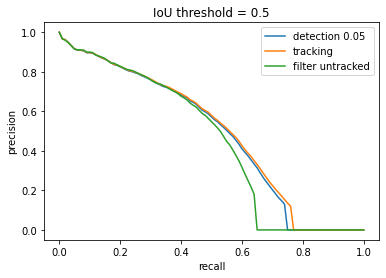

In [6]:
coco_evals = []
coco_evals.append(("detection 0.05", evaluate(predictions)))
coco_evals.append(("tracking", evaluate(predicted_after_tracking)))
coco_evals.append(("filter untracked", evaluate(predicted_after_filter_untracked)))

recall = np.linspace(.0, 1.00, int(np.round((1.00 - .0) / .01)) + 1, endpoint=True)
for model, coco_eval in coco_evals:
    plt.plot(recall, coco_eval.eval['precision'][0, :, 0, 0, -1], label=model)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title(f'IoU threshold = 0.5')
plt.legend()
plt.show()

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.76s).
Accumulating evaluation results...
DONE (t=1.58s).
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.03s).
Accumulating evaluation results...
DONE (t=1.58s).
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.88s).
Accumulating evaluation results...
DONE (t=1.25s).
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Loading and preparing results...

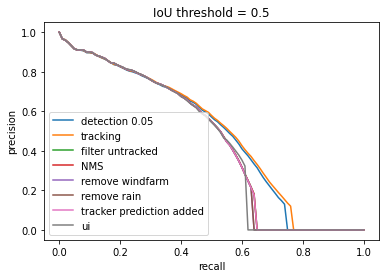

In [7]:
coco_evals = []
coco_evals.append(("detection 0.05", evaluate(predictions)))
coco_evals.append(("tracking", evaluate(predicted_after_tracking)))
coco_evals.append(("filter untracked", evaluate(predicted_after_filter_untracked)))
coco_evals.append(("NMS", evaluate(predicted_after_nms)))
coco_evals.append(("remove windfarm", evaluate(predicted_after_rm_windfarm)))
coco_evals.append(("remove rain", evaluate(predicted_after_rm_rain)))
coco_evals.append(("tracker prediction added", evaluate(predicted_with_tracker_results)))
coco_evals.append(("ui", evaluate(predicted_ui)))

recall = np.linspace(.0, 1.00, int(np.round((1.00 - .0) / .01)) + 1, endpoint=True)
for model, coco_eval in coco_evals:
    plt.plot(recall, coco_eval.eval['precision'][0, :, 0, 0, -1], label=model)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title(f'IoU threshold = 0.5')
plt.legend()
plt.show()

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.25s).
Accumulating evaluation results...
DONE (t=1.60s).
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.98s).
Accumulating evaluation results...
DONE (t=1.64s).
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.97s).
Accumulating evaluation results...
DONE (t=1.29s).
loading annotations into memory...
Done (t=1.02s)
creating index...
index created!
Loading and preparing results...

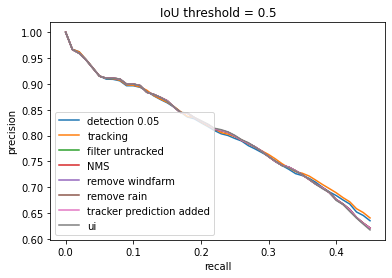

In [12]:
coco_evals = []
coco_evals.append(("detection 0.05", evaluate(predictions)))
coco_evals.append(("tracking", evaluate(predicted_after_tracking)))
coco_evals.append(("filter untracked", evaluate(predicted_after_filter_untracked)))
coco_evals.append(("NMS", evaluate(predicted_after_nms)))
coco_evals.append(("remove windfarm", evaluate(predicted_after_rm_windfarm)))
coco_evals.append(("remove rain", evaluate(predicted_after_rm_rain)))
coco_evals.append(("tracker prediction added", evaluate(predicted_with_tracker_results)))
coco_evals.append(("ui", evaluate(predicted_ui)))

recall = np.linspace(.0, 0.45, int(np.round((0.45 - .0) / .01)) + 1, endpoint=True)
for model, coco_eval in coco_evals:
    plt.plot(recall, coco_eval.eval['precision'][0, :len(recall), 0, 0, -1], label=model)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title(f'IoU threshold = 0.5')
plt.legend()
plt.show()

In [9]:
print(len(predictions))
print(len(predicted_after_tracking))
print(len(predicted_after_filter_untracked))
print(len(predicted_after_nms))
print(len(predicted_after_rm_windfarm))
print(len(predicted_after_rm_rain))
print(len(predicted_with_tracker_results))

66433
66433
36501
36501
36410
36171
38511


In [ ]:
coco_evals = []
coco_evals.append(("remove windfarm", evaluate(predicted_after_rm_windfarm)))
coco_evals.append(("remove rain", evaluate(predicted_after_rm_rain)))

recall = np.linspace(.0, 1.00, int(np.round((0.50 - .0) / .01)) + 1, endpoint=True)
for model, coco_eval in coco_evals:
    plt.plot(recall, coco_eval.eval['precision'][0, :, 0, 0, -1], label=model)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title(f'IoU threshold = 0.5')
plt.legend()
plt.show()

## Model Comparison

In [1]:
EXPs = [
    ("resnet50-c4", "2.1infer_entire_lr_0.00100_anchor_5_size_1200_resnet50-c4_ignore_49999"),
    ("resnet101-rpn", "3.2eval_resnet101-FPN_detptr_anc10_regsl1_imsz1200_lr0.001_it150k_ckpt39999_strt1")
]

In [3]:
import sys
import json
import os
import numpy as np
from pycocotools.coco import COCO
from roosts.evaluation.roosteval import COCOeval
import matplotlib.pyplot as plt

coco_evals = []

for model, exp in EXPs:
    # test dataset
    dataset_name = "roosts_v0.1.0_test"
    task = "bbox"
    coco_gt = COCO(os.path.join(exp, f"{dataset_name}_coco_format.json"))

    # predictions
    with open(os.path.join(exp, "coco_instances_results.json"), "r") as f:
        prediction_json = json.load(f)
    coco_dt = coco_gt.loadRes(prediction_json)

    # evaluate
    coco_eval = COCOeval(coco_gt, coco_dt, task)
    coco_eval.evaluate()
    coco_eval.accumulate()
        # coco_eval.eval['precision'].shape = (10, 101, 1, 4, 3)
        # IoU thres 0.50:0.05:0.95
        # recall thres 0:0.01:1
        # 1 class
        # gt filter [[0 ** 2, 1e5 ** 2], [0 ** 2, 32 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]
        # dt filter top-scoring [1, 10, 100]
    
    coco_evals.append((model, coco_eval))

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.57s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=21.88s).
Accumulating evaluation results...
DONE (t=5.63s).
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.23s).
Accumulating evaluation results...
DONE (t=5.12s).


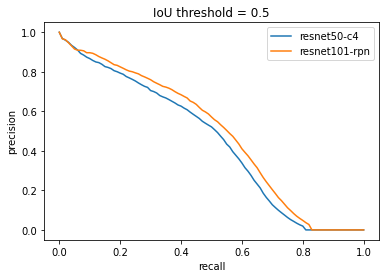

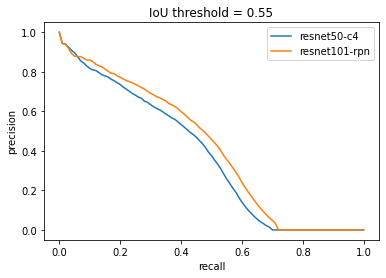

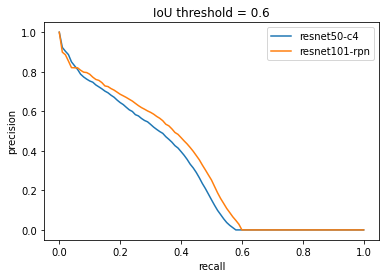

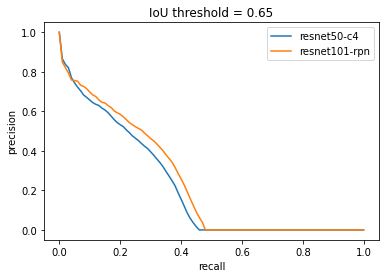

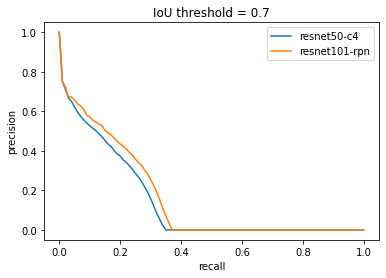

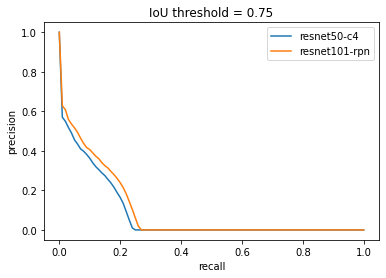

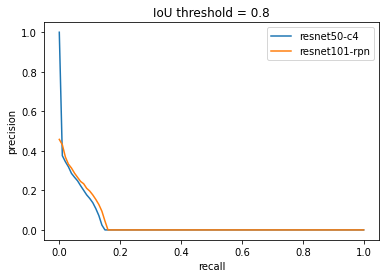

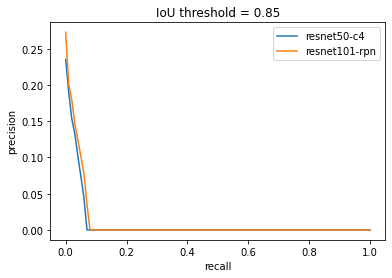

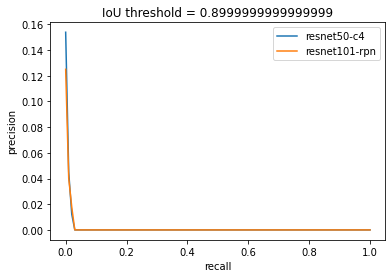

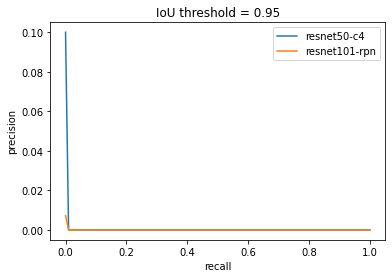

In [10]:
ious = np.linspace(.5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
recall = np.linspace(.0, 1.00, int(np.round((1.00 - .0) / .01)) + 1, endpoint=True)
for i, iou in enumerate(ious):
    for model, coco_eval in coco_evals:
        plt.plot(recall, coco_eval.eval['precision'][i, :, 0, 0, -1], label=model)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title(f'IoU threshold = {iou}')
    plt.legend()
    plt.show()